## Import packages

In [2]:
import sys
print(sys.version)

# !pip install rasterio

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datetime import datetime, timedelta
from rasterio.plot import show
import math

import pandas as pd
import rasterio

import glob
import os

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

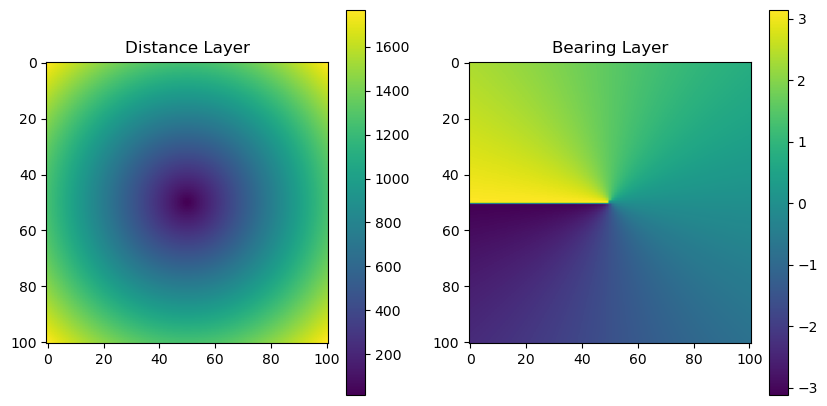

In [3]:
image_dim = 101
pixel_size = 25
center = image_dim // 2
y, x = np.indices((image_dim, image_dim))

distance_layer = np.sqrt((pixel_size*(x - center))**2 + (pixel_size*(y - center))**2)
# change the centre cell to the average distance from the centre to the edge of the pixel
distance_layer[center, center] = 0.56*pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
bearing_layer = np.arctan2(center - y, x - center)

# plot both of the layers
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(distance_layer)
ax[0].set_title('Distance Layer')
# add colour scale
cbar = plt.colorbar(ax[0].imshow(distance_layer), ax=ax[0])
ax[1].imshow(bearing_layer)
ax[1].set_title('Bearing Layer')
# add colour scale
cbar = plt.colorbar(ax[1].imshow(bearing_layer), ax=ax[1])
plt.show()


# Import data

In [4]:
# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# select the id to train the model on
buffalo_id = 2005
n_samples = 10297

# buffalo_id = 2014
# n_samples = 6572

# buffalo_id = 2327
# n_samples = 8983

# buffalo_id = 2387
# n_samples = 10409

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/validation/validation_buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

# Lag the values in column 'A' by one index
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

         ta    cos_ta         x_min         x_max         y_min         y_max  \
0  1.367942  0.20

## Importing spatial data

## Sentinel-2 bands

Each stack represents a month of median values of cloud-free pixels, and each layer in the stack are the bands.


In [5]:
# Step 1: Specify the directory containing your TIFF files
data_dir = '../mapping/cropped rasters/sentinel2/25m'  # Replace with the actual path to your TIFF files

# Step 2: Use glob to get a list of all TIFF files matching the pattern
tif_files = glob.glob(os.path.join(data_dir, 'S2_SR_masked_25m_*.tif'))
print(f'Found {len(tif_files)} TIFF files')
print('\n'.join(tif_files))

Found 12 TIFF files
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_01.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_02.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_03.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_04.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_05.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_06.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_07.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_08.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_09.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_10.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_11.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_25m_2019_12.tif


In [6]:
# Step 3: Initialize a dictionary to store data with date as the key
data_dict = {}

# Step 4: Define the min and max values for normalization for each band
# Values are from the buffalo 2005 local layers
band_normalization = {
              "Band1": {"min": 1.0, "max": 1517.0848},
              "Band2": {"min": 28.1072, "max": 1931.7552},
              "Band3": {"min": 210.9864, "max": 2795.7568},
              "Band4": {"min": 65.7832, "max": 4386.7969},
              "Band5": {"min": 358.7600, "max": 4592.7358},
              "Band6": {"min": 385.3400, "max": 5120.9146},
              "Band7": {"min": 416.5744, "max": 6045.6992},
              "Band8": {"min": 368.0320, "max": 6004.5825},
              "Band8a": {"min": 357.0704, "max": 6218.4136},
              "Band9": {"min": 123.0, "max": 5680.5000},
              "Band11": {"min": 174.1200, "max": 6570.3921},
              "Band12": {"min": 123.3760, "max": 5119.9966}
}

# # Define the min and max values for normalization for each band - when all scaled by 10000
# band_normalization = {
#     "Band1": {"min": 0.0, "max": 10000.0},
#     "Band2": {"min": 0.0, "max": 10000.0},
#     "Band3": {"min": 0.0, "max": 10000.0},
#     "Band4": {"min": 0.0, "max": 10000.0},
#     "Band5": {"min": 0.0, "max": 10000.0},
#     "Band6": {"min": 0.0, "max": 10000.0},
#     "Band7": {"min": 0.0, "max": 10000.0},
#     "Band8": {"min": 0.0, "max": 10000.0},
#     "Band8a": {"min": 0.0, "max": 10000.0},
#     "Band9": {"min": 0.0, "max": 10000.0},
#     "Band11": {"min": 0.0, "max": 10000.0},
#     "Band12": {"min": 0.0, "max": 10000.0}
# }

print(band_normalization)

{'Band1': {'min': 1.0, 'max': 1517.0848}, 'Band2': {'min': 28.1072, 'max': 1931.7552}, 'Band3': {'min': 210.9864, 'max': 2795.7568}, 'Band4': {'min': 65.7832, 'max': 4386.7969}, 'Band5': {'min': 358.76, 'max': 4592.7358}, 'Band6': {'min': 385.34, 'max': 5120.9146}, 'Band7': {'min': 416.5744, 'max': 6045.6992}, 'Band8': {'min': 368.032, 'max': 6004.5825}, 'Band8a': {'min': 357.0704, 'max': 6218.4136}, 'Band9': {'min': 123.0, 'max': 5680.5}, 'Band11': {'min': 174.12, 'max': 6570.3921}, 'Band12': {'min': 123.376, 'max': 5119.9966}}


In [7]:
# Step 5: Loop over each TIFF file to read and process the data
for tif_file in tif_files:
    # Extract the filename from the path
    filename = os.path.basename(tif_file)
    
    # Extract the date from the filename
    # Assuming filenames are in the format 'S2_SR_masked_YYYY_MM.tif'
    date_str = filename.replace('S2_SR_masked_25m_', '').replace('.tif', '')
    # date_str will be something like '2019_01'
    
    # Read the TIFF file using rasterio
    with rasterio.open(tif_file) as src:
        # Read all bands of the TIFF file
        data = src.read()
        # 'data' is a NumPy array with shape (bands, height, width)
        
        # Initialize an array to store normalized data
        normalized_data = np.zeros_like(data, dtype=np.float32)
        
        # Loop over each band to perform normalization
        for i, (band_name, values) in enumerate(band_normalization.items()):
            # Get the data for the current band
            band_data = data[i]
            
            # Get the corresponding min and max values for this band
            band_min = values['min']
            band_max = values['max']

            # Replace NaN values in the original data with the band minimum
            band_data = np.nan_to_num(band_data, nan=band_min)
            
            # Perform min-max normalization to scale data between 0 and 1
            # Avoid division by zero by checking if (max - min) is not zero
            if band_max - band_min != 0:
                normalized_band = (band_data - band_min) / (band_max - band_min)
            else:
                # If max and min are the same, set normalized data to zero
                normalized_band = np.zeros_like(band_data, dtype=np.float32)
            
            # Store the normalized band data
            normalized_data[i] = normalized_band

            # Check the normalization for the current band
            print(f"Band {i + 1} of {date_str}:")
            print(f"Original min: {band_data.min()}, Original max: {band_data.max()}")
            print(f"Normalized min: {normalized_band.min()}, Normalized max: {normalized_band.max()}")
            print("-" * 50)

            # # Plot the first few layers (bands) for visualization
            # if i < 3:  # Change the number of bands you want to plot by adjusting this condition
            #     plt.figure(figsize=(8, 6))
            #     plt.imshow(normalized_band, cmap='viridis')  # You can change the colormap as needed
            #     plt.colorbar() # label='Normalized Value'
            #     plt.title(f'Band {i + 1} - {date_str}')
            #     plt.show()
        
        # Add the normalized data to the dictionary with date as the key
        data_dict[date_str] = normalized_data

Band 1 of 2019_01:
Original min: 1.0, Original max: 3130.509521484375
Normalized min: 0.0, Normalized max: 2.064204692840576
--------------------------------------------------
Band 2 of 2019_01:
Original min: 28.107200622558594, Original max: 4062.55517578125
Normalized min: 0.0, Normalized max: 2.1193246841430664
--------------------------------------------------
Band 3 of 2019_01:
Original min: 106.44960021972656, Original max: 4883.92333984375
Normalized min: -0.040443360805511475, Normalized max: 1.8078731298446655
--------------------------------------------------
Band 4 of 2019_01:
Original min: 65.783203125, Original max: 5488.09619140625
Normalized min: 0.0, Normalized max: 1.2548705339431763
--------------------------------------------------
Band 5 of 2019_01:
Original min: 120.79679870605469, Original max: 5836.35107421875
Normalized min: -0.05620325356721878, Normalized max: 1.2937228679656982
--------------------------------------------------
Band 6 of 2019_01:
Original min

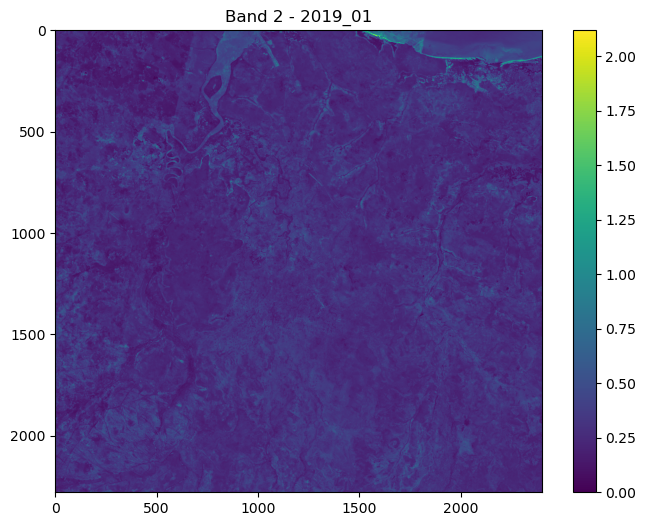

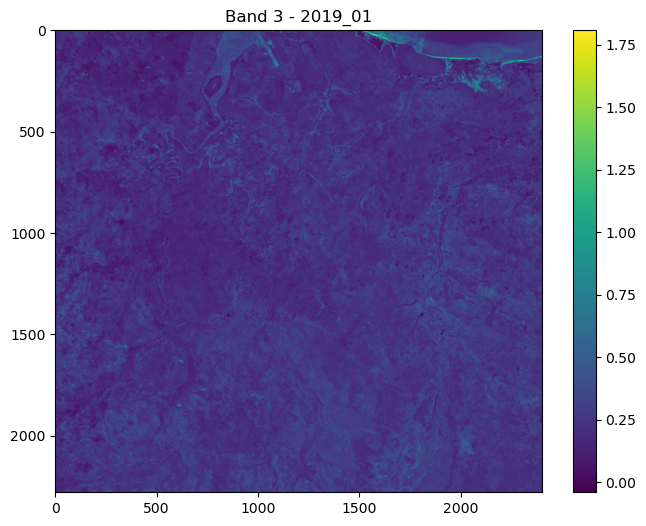

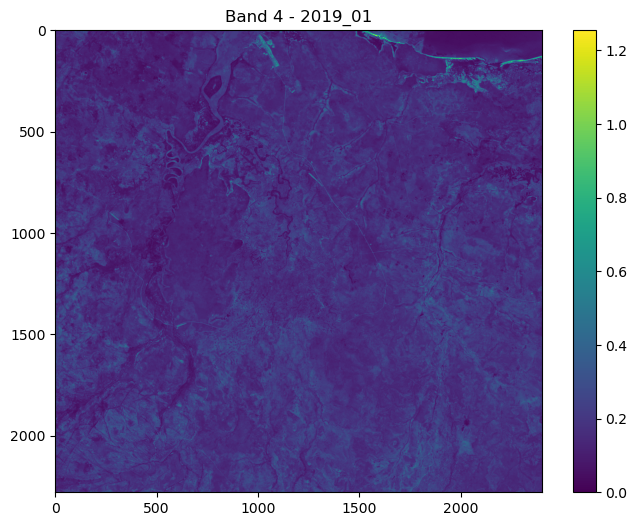

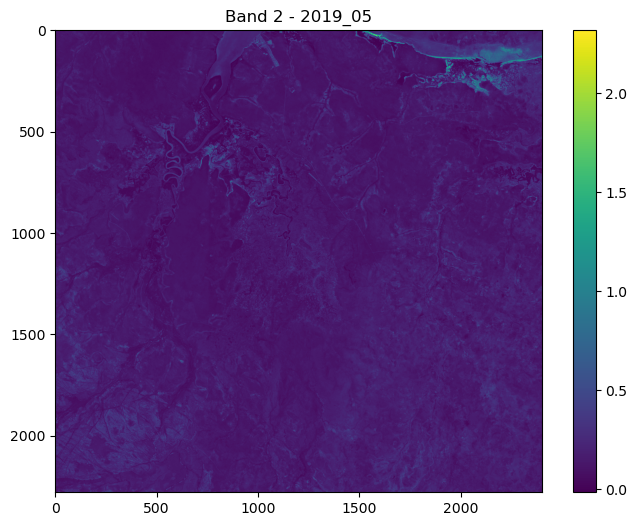

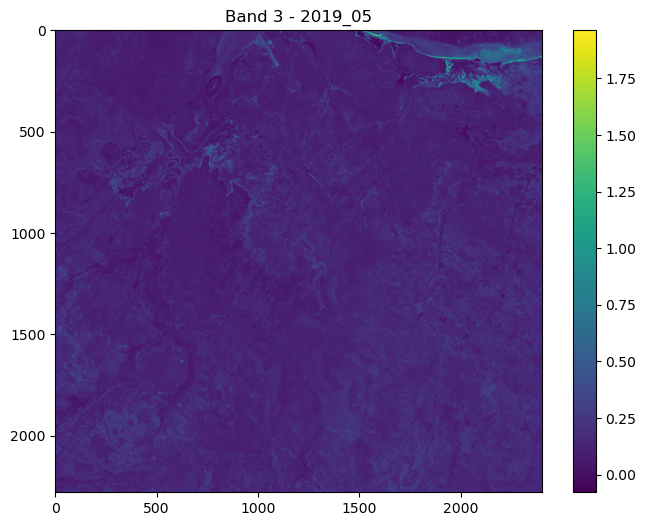

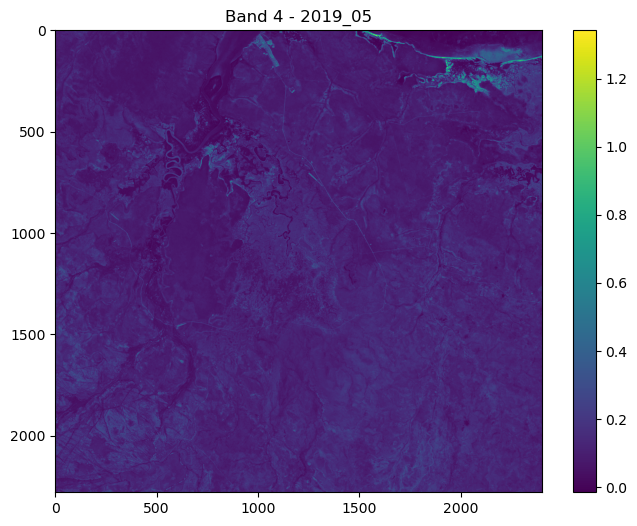

In [8]:
# Step 6: Select some bands from the processed data stored in 'data_dict' for plotting
layers_to_plot = []

# Specify the date and band numbers you want to plot
dates_to_plot = ['2019_01', '2019_05']  # This grabs all available dates. You can select specific ones if needed.
bands_to_plot = [1, 2, 3]  # Band indices for bands 2, 3, and 4, which are B, G, and R

# Loop through the selected dates and bands to prepare them for plotting
for date_str in dates_to_plot:
    normalized_data = data_dict[date_str]  # Get the normalized data for this date
    
    for band_idx in bands_to_plot:
        # Collect the specific band for plotting
        layers_to_plot.append((normalized_data[band_idx], band_idx + 1, date_str))

# random layers to test plotting function
# layers_to_plot = [
#     (np.random.rand(100, 100), 1, '2023-01-01'),
#     (np.random.rand(100, 100), 2, '2023-02-01'),
#     (np.random.rand(100, 100), 3, '2023-03-01')
# ]

# Step 7: Plot the stored layers
for normalized_band, band_number, date_str in layers_to_plot:
    plt.figure(figsize=(8, 6))
    plt.imshow(normalized_band, cmap='viridis') 
    plt.title(f'Band {band_number} - {date_str}')
    plt.colorbar() #label='Normalized Value'
    plt.show()


### Slope

In [9]:
file_path = '../mapping/cropped rasters/slope.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_global = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta
    raster_transform = src.transform # same as the raster transform in the NDVI raster read

print(slope_global)
print(raster_transform)


[[       nan        nan        nan ...        nan        nan        nan]
 [       nan 0.3352837  0.39781624 ... 0.         0.                nan]
 [       nan 0.3983888  0.48142004 ... 0.         0.                nan]
 ...
 [       nan 2.215875   1.9798415  ... 1.5078747  1.268342          nan]
 [       nan 1.9740707  1.7354656  ... 1.697194   1.4880029         nan]
 [       nan        nan        nan ...        nan        nan        nan]]
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


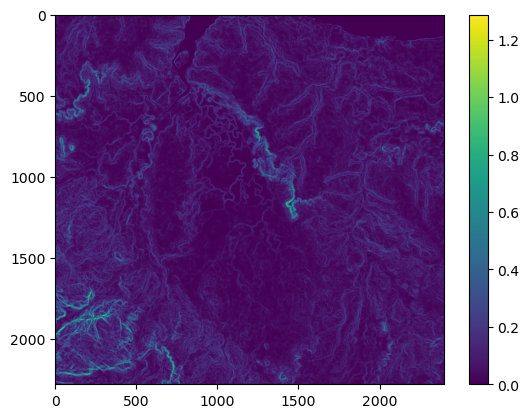

In [10]:
print(slope_meta)
print(slope_global.shape)

# Replace NaNs in the original array with -1, which represents water
slope_global = np.nan_to_num(slope_global, nan=0.0)

# from the stack of local layers
slope_max = 12.2981
slope_min = 0.0006

slope_global_tens = torch.from_numpy(slope_global)

# Normalizing the data
slope_global_norm = (slope_global_tens - slope_min) / (slope_max - slope_min)

plt.imshow(slope_global_norm.numpy())
plt.colorbar()  
plt.show()


## Global layers

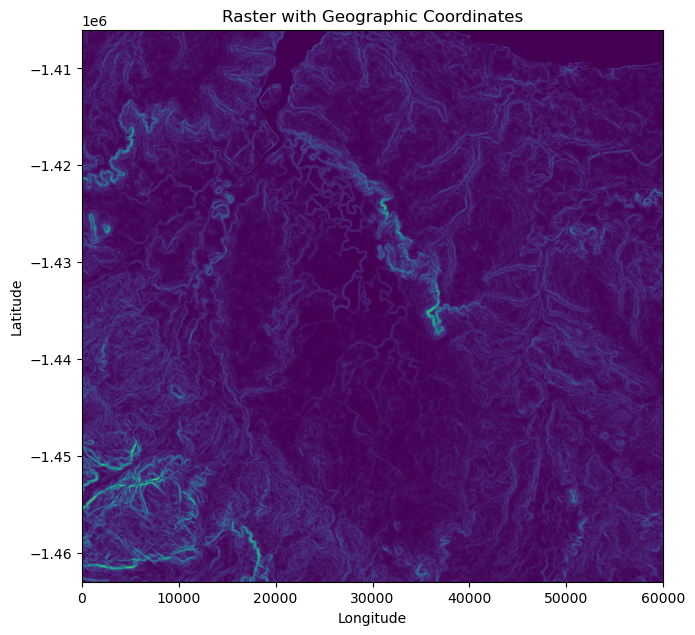

In [11]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))

# Plot the raster
show(slope_global, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('Raster with Geographic Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

### Going between cell and raster coordinates

In [12]:
x, y = 5.9e4, -1.447e6
print(x, y)

# Convert geographic coordinates to pixel coordinates
px, py = ~raster_transform * (x, y)
# Round pixel coordinates to integers
px, py = int(round(px)), int(round(py))

# Print the pixel coordinates	
print(px, py)

59000.0 -1447000.0
2360 1640


## Subset function

In [13]:
def subset_raster_with_padding_torch(raster_tensor, x, y, window_size, transform):
    # Convert geographic coordinates to pixel coordinates
    px, py = ~transform * (x, y)
    
    # Round pixel coordinates to integers
    # px, py = int(round(px)), int(round(py)) # this will go to the cell adjacent when above 0.5 - which is NOT what we want
    px, py = int(px), int(py) # this will always round towards zero, therefore staying in the same cell
    
    # Define half the window size
    half_window = window_size // 2
    
    # Calculate the window boundaries
    row_start = py - half_window
    row_stop = py + half_window + 1
    col_start = px - half_window
    col_stop = px + half_window + 1
    
    # Initialize the subset tensor with zeros (or any other padding value)
    subset = torch.full((window_size, window_size), -1.0, dtype=raster_tensor.dtype)
    
    # Calculate the valid region within the raster bounds
    valid_row_start = max(0, row_start)
    valid_row_stop = min(raster_tensor.shape[0], row_stop)
    valid_col_start = max(0, col_start)
    valid_col_stop = min(raster_tensor.shape[1], col_stop)
    
    # Calculate the corresponding region in the subset tensor
    subset_row_start = valid_row_start - row_start
    subset_row_stop = subset_row_start + (valid_row_stop - valid_row_start)
    subset_col_start = valid_col_start - col_start
    subset_col_stop = subset_col_start + (valid_col_stop - valid_col_start)
    
    # Copy the valid region from the raster tensor to the subset tensor
    subset[subset_row_start:subset_row_stop, subset_col_start:subset_col_stop] = \
        raster_tensor[valid_row_start:valid_row_stop, valid_col_start:valid_col_stop]
    
    return subset, col_start, row_start

Testing the subset function

torch.Size([12, 2280, 2400])


Text(0.5, 1.0, 'Slope Subset')

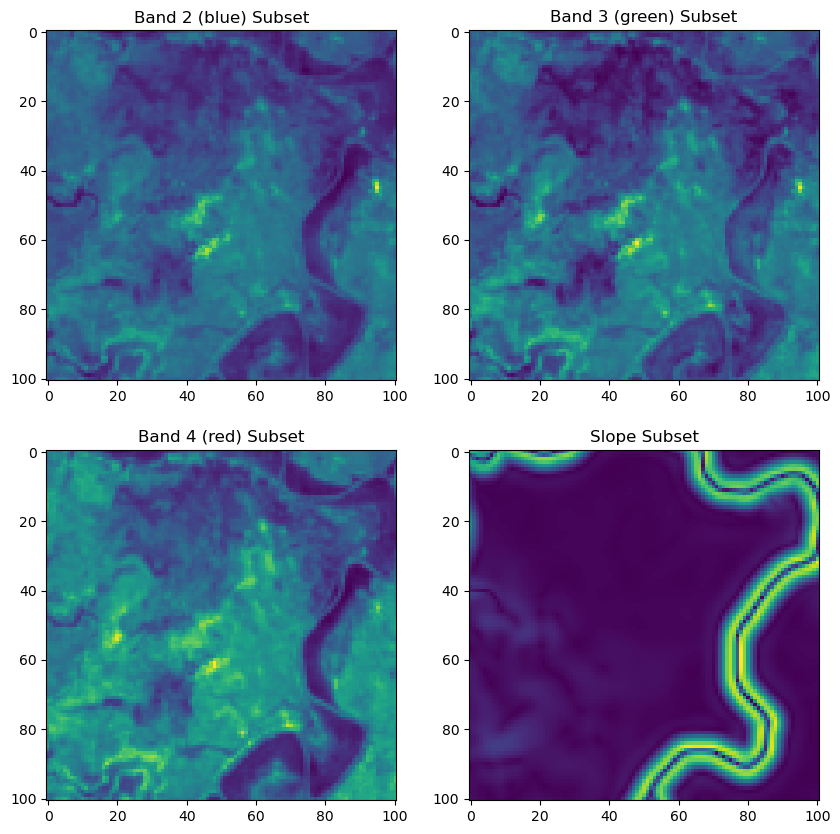

In [14]:
x = 2.8e4
y = -1.43e6
window_size = 101

which_ndvi = 1

# ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_global_norm[which_ndvi,:,:], x, y, window_size, raster_transform)
# canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_global_norm, x, y, window_size, raster_transform)
# herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_global_norm, x, y, window_size, raster_transform)
slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, raster_transform)

# for sentinel 2 data
selected_month = '2019_01'
# Get the normalized data for the selected month
s2_data = data_dict[selected_month]

# Convert the NumPy array to a PyTorch tensor
s2_tensor = torch.from_numpy(s2_data)
s2_tensor = s2_tensor.float()  # Ensure the tensor is of type float
print(s2_tensor.shape)

s2_b1_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[0,:,:], x, y, window_size, raster_transform)
s2_b2_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[1,:,:], x, y, window_size, raster_transform)
s2_b3_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[2,:,:], x, y, window_size, raster_transform)
s2_b4_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[3,:,:], x, y, window_size, raster_transform)
s2_b5_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[4,:,:], x, y, window_size, raster_transform)
s2_b6_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[5,:,:], x, y, window_size, raster_transform)
s2_b7_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[6,:,:], x, y, window_size, raster_transform)
s2_b8_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[7,:,:], x, y, window_size, raster_transform)
s2_b8a_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[8,:,:], x, y, window_size, raster_transform)
s2_b9_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[9,:,:], x, y, window_size, raster_transform)
s2_b11_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[10,:,:], x, y, window_size, raster_transform)
s2_b12_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[11,:,:], x, y, window_size, raster_transform)

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(s2_b2_subset.detach().numpy(), cmap='viridis')
axs[0, 0].set_title('Band 2 (blue) Subset')
# axs[0, 0].axis('off')

axs[0, 1].imshow(s2_b3_subset.detach().numpy(), cmap='viridis')
axs[0, 1].set_title('Band 3 (green) Subset')
# # axs[0, 1].axis('off')

axs[1, 0].imshow(s2_b4_subset.detach().numpy(), cmap='viridis')
axs[1, 0].set_title('Band 4 (red) Subset')
# # axs[1, 0].axis('off')

axs[1, 1].imshow(slope_subset.detach().numpy(), cmap='viridis')
axs[1, 1].set_title('Slope Subset')
# axs[1, 1].axis('off')


### Save the plots individually

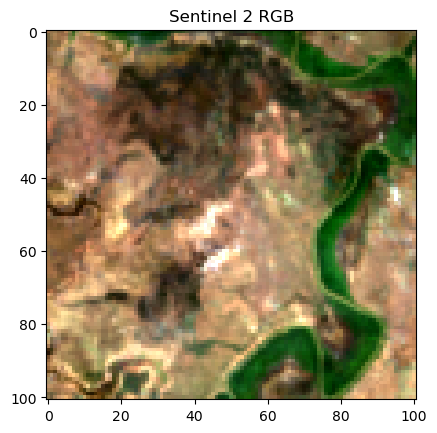

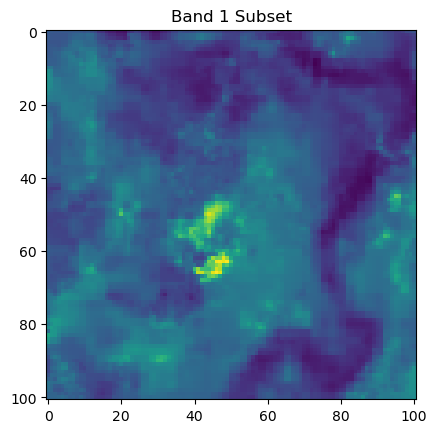

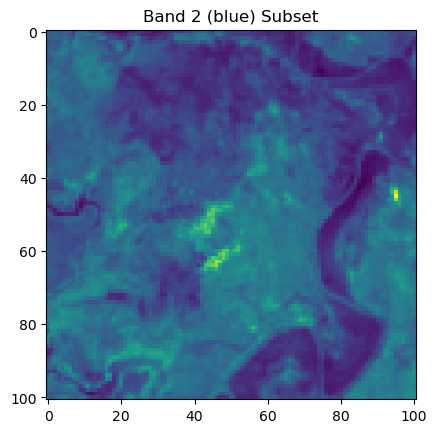

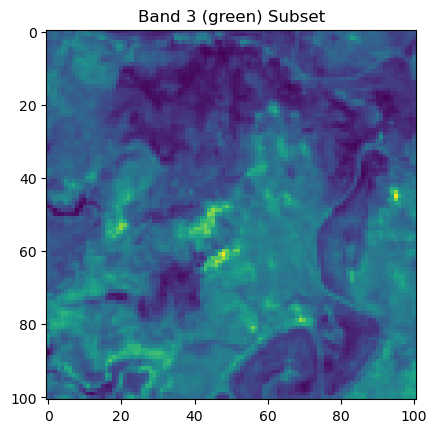

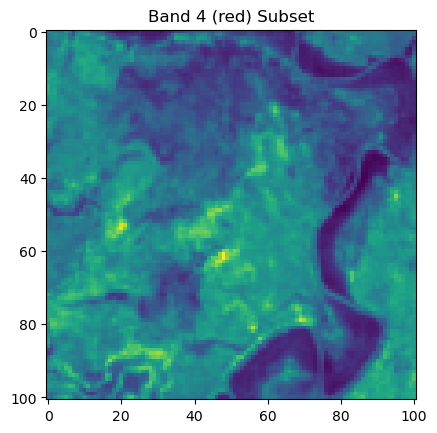

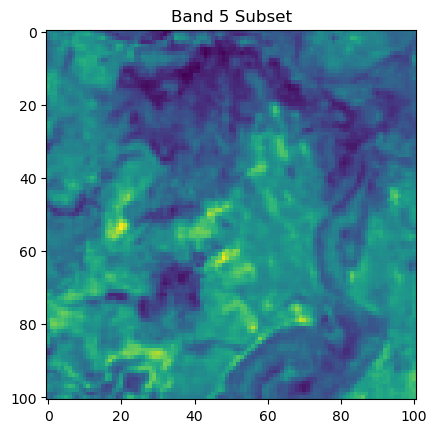

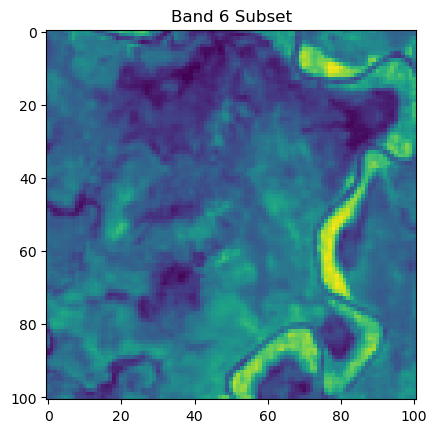

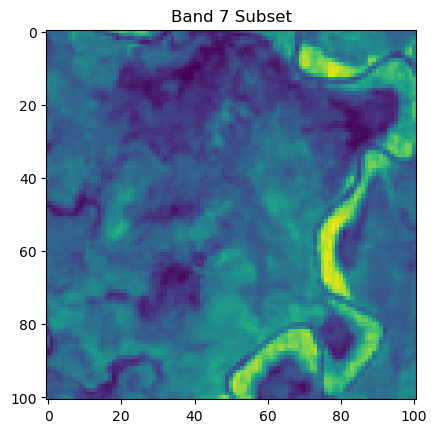

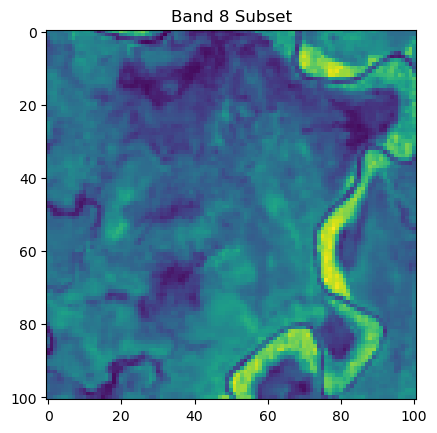

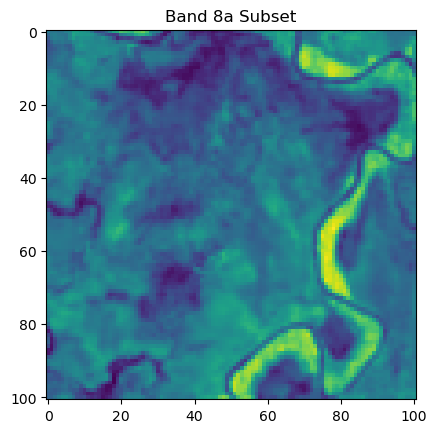

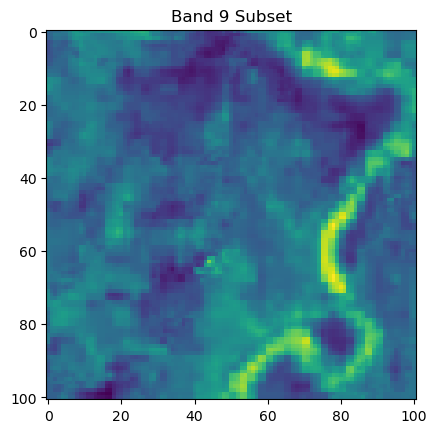

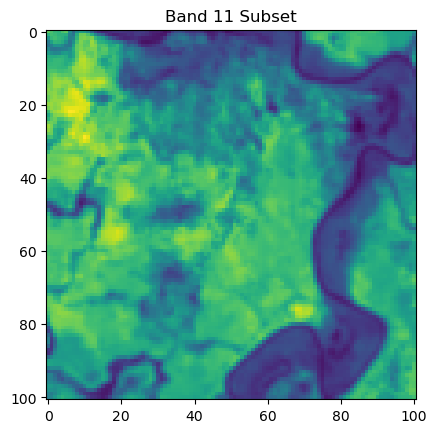

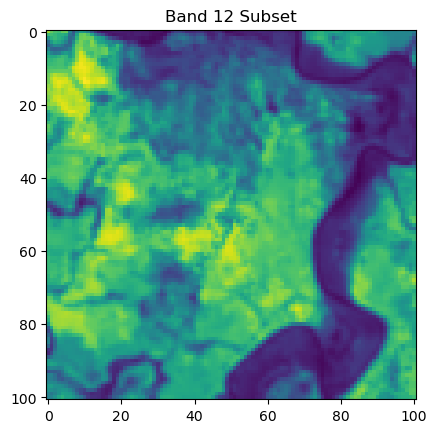

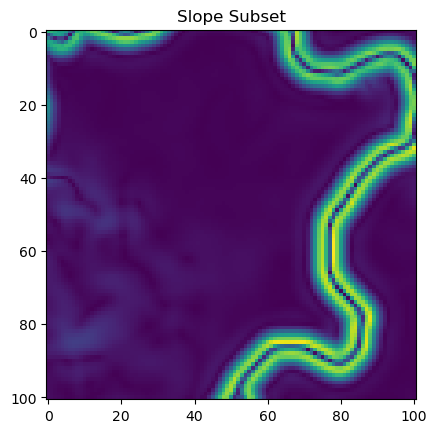

In [17]:
output_dir = f'outputs/s2_plots'
os.makedirs(output_dir, exist_ok=True)

# RGB for plotting
# pull out the RGB bands
r_band = s2_b4_subset.detach().numpy()
g_band = s2_b3_subset.detach().numpy()
b_band = s2_b2_subset.detach().numpy()

# Reverse the normalization process using the original min and max values
r_band = r_band * (band_normalization["Band4"]["max"] - band_normalization["Band4"]["min"]) + band_normalization["Band4"]["min"]
g_band = g_band * (band_normalization["Band3"]["max"] - band_normalization["Band3"]["min"]) + band_normalization["Band3"]["min"]
b_band = b_band * (band_normalization["Band2"]["max"] - band_normalization["Band2"]["min"]) + band_normalization["Band2"]["min"]

# Stack the bands along a new axis; here, -1 is used for the channel axis in NumPy
rgb_image = np.stack([r_band, g_band, b_band], axis=-1)

p1 = np.percentile(rgb_image, 1)
p99 = np.percentile(rgb_image, 99)

rgb_image = np.clip(rgb_image, p1, p99)
rgb_image = (rgb_image - p1) / (p99 - p1)

gamma = 1.1  # Adjust gamma value as needed
rgb_image = np.power(rgb_image, gamma)

# Plot s2_b2
plt.imshow(rgb_image)
plt.title('Sentinel 2 RGB')
plt.savefig(f'{output_dir}/rgb_subset.png', dpi=600, bbox_inches='tight')
# fig_out.colorbar(im1, ax=axs_out[0, 0], shrink=0.7)
plt.show()
plt.close()

# plot the covariates
plt.imshow(s2_b1_subset.detach().numpy(), cmap='viridis')
plt.title('Band 1 Subset')
plt.savefig(f'{output_dir}/s2_b1_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b2_subset.detach().numpy(), cmap='viridis')
plt.title('Band 2 (blue) Subset')
plt.savefig(f'{output_dir}/s2_b2_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b3_subset.detach().numpy(), cmap='viridis')
plt.title('Band 3 (green) Subset')
plt.savefig(f'{output_dir}/s2_b3_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b4_subset.detach().numpy(), cmap='viridis')
plt.title('Band 4 (red) Subset')
plt.savefig(f'{output_dir}/s2_b4_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b5_subset.detach().numpy(), cmap='viridis')
plt.title('Band 5 Subset')
plt.savefig(f'{output_dir}/s2_b5_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b6_subset.detach().numpy(), cmap='viridis')
plt.title('Band 6 Subset')
plt.savefig(f'{output_dir}/s2_b6_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b7_subset.detach().numpy(), cmap='viridis')
plt.title('Band 7 Subset')
plt.savefig(f'{output_dir}/s2_b7_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b8_subset.detach().numpy(), cmap='viridis')
plt.title('Band 8 Subset')
plt.savefig(f'{output_dir}/s2_b8_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b8a_subset.detach().numpy(), cmap='viridis')
plt.title('Band 8a Subset')
plt.savefig(f'{output_dir}/s2_b8a_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b9_subset.detach().numpy(), cmap='viridis')
plt.title('Band 9 Subset')
plt.savefig(f'{output_dir}/s2_b9_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b11_subset.detach().numpy(), cmap='viridis')
plt.title('Band 11 Subset')
plt.savefig(f'{output_dir}/s2_b11_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(s2_b12_subset.detach().numpy(), cmap='viridis')
plt.title('Band 12 Subset')
plt.savefig(f'{output_dir}/s2_b12_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(slope_subset.detach().numpy(), cmap='viridis')
plt.title('Slope Subset')
plt.savefig(f'{output_dir}/slope_subset.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Running the model on the subset layers

### Set the device for the model

In [50]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


# Define the model

In [22]:
class Conv2d_block_toFC(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_toFC, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Flatten())

    def forward(self, x):
        return self.conv2d(x)


class Conv2d_block_spatial(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_spatial, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        # self.kernel_size_mp = params.kernel_size_mp
        # self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        )

    def forward(self, x):
        # print("Shape before squeeze:", self.conv2d(x).shape)
        conv2d_spatial = self.conv2d(x).squeeze(dim = 1)
        # print("Shape before logsumexp:", conv2d_spatial.shape)

        # normalise before combining with the movement grid
        conv2d_spatial = conv2d_spatial - torch.logsumexp(conv2d_spatial, dim = (1, 2), keepdim = True)

        # conv2d_spatial = conv2d_spatial/torch.sum(conv2d_spatial)
        return conv2d_spatial


class FCN_block_all_habitat(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_habitat, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.image_dim * self.image_dim)
        )

    def forward(self, x):
        return self.ffn(x)


class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )

    def forward(self, x):
        return self.ffn(x)

class FCN_block_nonspatial(nn.Module):
    def __init__(self, params):
        super(FCN_block_nonspatial, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_nonspatial = params.dense_dim_in_nonspatial
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_nonspatial, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_out)
        )

    def forward(self, x):
        return self.ffn(x)



##################################################
# Mixture of two Gamma and von Mises distributions with the von Mises mu parameters allowed to vary
##################################################

class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        # change the centre cell to the average distance from the centre to the edge of the pixel
        self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
        # self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
        self.bearing_layer = torch.from_numpy(np.arctan2(self.center - y, x - self.center))
        self.device = params.device


    # Gamma desnities for the mixture distribution
    def gamma_density(self, x, shape, scale):
        # Ensure all tensors are on the same device as x
        shape = shape.to(x.device)
        scale = scale.to(x.device)
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

    # von Mises densities for the mixture distribution
    def vonmises_density(self, x, kappa, vm_mu):
        # Ensure all tensors are on the same device as x
        kappa = kappa.to(x.device)
        vm_mu = vm_mu.to(x.device)
        return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


    def forward(self, x, bearing):

        # parameters of the first mixture distribution
        gamma_shape1 = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape1 = gamma_shape1.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape1 = gamma_shape1.permute(2, 0, 1)

        gamma_scale1 = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale1 = gamma_scale1.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale1 = gamma_scale1.permute(2, 0, 1)

        gamma_weight1 = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        gamma_weight1 = gamma_weight1.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight1 = gamma_weight1.permute(2, 0, 1)

        # parameters of the second mixture distribution
        gamma_shape2 = torch.exp(x[:, 3]).unsqueeze(0).unsqueeze(0)
        gamma_shape2 = gamma_shape2.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape2 = gamma_shape2.permute(2, 0, 1)

        gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)
        gamma_scale2 = gamma_scale2 * 500 ### to transform the scale parameter to be near 1
        gamma_scale2 = gamma_scale2.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale2 = gamma_scale2.permute(2, 0, 1)

        gamma_weight2 = torch.exp(x[:, 5]).unsqueeze(0).unsqueeze(0)
        gamma_weight2 = gamma_weight2.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight2 = gamma_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        gamma_weights = torch.stack([gamma_weight1, gamma_weight2], dim=0)
        gamma_weights = torch.nn.functional.softmax(gamma_weights, dim=0)
        gamma_weight1 = gamma_weights[0]
        gamma_weight2 = gamma_weights[1]

        # calculation of Gamma densities
        gamma_density_layer1 = self.gamma_density(self.distance_layer, gamma_shape1, gamma_scale1).to(device)
        gamma_density_layer2 = self.gamma_density(self.distance_layer, gamma_shape2, gamma_scale2).to(device)

        # combining both densities to create a mixture distribution using logsumexp
        logsumexp_gamma_corr = torch.max(gamma_density_layer1, gamma_density_layer2)
        gamma_density_layer = logsumexp_gamma_corr + torch.log(gamma_weight1 * torch.exp(gamma_density_layer1 - logsumexp_gamma_corr) + gamma_weight2 * torch.exp(gamma_density_layer2 - logsumexp_gamma_corr))
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))

        # normalise the gamma weights so they sum to 1
        # gamma_density_layer = gamma_density_layer - torch.logsumexp(gamma_density_layer, dim = (1, 2), keepdim = True)

        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))


        ## Von Mises Distributions

        # calculate the new bearing from the turning angle
        # takes in the bearing from the previous step and adds the turning angle
        bearing_new1 = x[:, 6] + bearing[:, 0]
        # bearing_new1 = 0.0 + bearing[:, 0]

        # print('Bearing.shape ', bearing.shape)
        # print('Bearing[:, 0].shape ', bearing[:, 0].shape)
        # print('Bearing[:, 0] ', bearing[:, 0])
        # the new bearing becomes the mean of the von Mises distribution
        # the estimated parameter [x:, 7] is the turning angle of the next step
        # which is always in reference to the input bearing
        vonmises_mu1 = bearing_new1.unsqueeze(0).unsqueeze(0)
        vonmises_mu1 = vonmises_mu1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu1 = vonmises_mu1.permute(2, 0, 1)

        # parameters of the first von Mises distribution
        vonmises_kappa1 = torch.exp(x[:, 7]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa1 = vonmises_kappa1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa1 = vonmises_kappa1.permute(2, 0, 1)

        vonmises_weight1 = torch.exp(x[:, 8]).unsqueeze(0).unsqueeze(0)
        vonmises_weight1 = vonmises_weight1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight1 = vonmises_weight1.permute(2, 0, 1)

        # vm_mu and weight for the second von Mises distribution
        bearing_new2 = x[:, 9] + bearing[:, 0]
        # bearing_new2 = torch.pi + bearing[:, 0]
        # bearing_new2 = -torch.pi + bearing[:, 0]

        vonmises_mu2 = bearing_new2.unsqueeze(0).unsqueeze(0)
        vonmises_mu2 = vonmises_mu2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu2 = vonmises_mu2.permute(2, 0, 1)

        # parameters of the second von Mises distribution
        vonmises_kappa2 = torch.exp(x[:, 10]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa2 = vonmises_kappa2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa2 = vonmises_kappa2.permute(2, 0, 1)

        vonmises_weight2 = torch.exp(x[:, 11]).unsqueeze(0).unsqueeze(0)
        vonmises_weight2 = vonmises_weight2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight2 = vonmises_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        vonmises_weights = torch.stack([vonmises_weight1, vonmises_weight2], dim=0)
        vonmises_weights = torch.nn.functional.softmax(vonmises_weights, dim=0)
        vonmises_weight1 = vonmises_weights[0]
        vonmises_weight2 = vonmises_weights[1]

        # calculation of von Mises densities
        vonmises_density_layer1 = self.vonmises_density(self.bearing_layer, vonmises_kappa1, vonmises_mu1).to(device)
        vonmises_density_layer2 = self.vonmises_density(self.bearing_layer, vonmises_kappa2, vonmises_mu2).to(device)

        # combining both densities to create a mixture distribution using the logsumexp trick
        logsumexp_vm_corr = torch.max(vonmises_density_layer1, vonmises_density_layer2)
        vonmises_density_layer = logsumexp_vm_corr + torch.log(vonmises_weight1 * torch.exp(vonmises_density_layer1 - logsumexp_vm_corr) + vonmises_weight2 * torch.exp(vonmises_density_layer2 - logsumexp_vm_corr))
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # normalise so the densities sum to 1 when exponentiated
        # vonmises_density_layer = vonmises_density_layer - torch.logsumexp(vonmises_density_layer, dim = (1, 2), keepdim = True)
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # combining the two distributions
        movement_grid = gamma_density_layer + vonmises_density_layer # Gamma and von Mises densities are on the log-scale
        # print('Movement grid ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        # normalise before combining with the habitat predictions
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)

        # print('Movement grid norm ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        return movement_grid


class Scalar_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Scalar_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device

    def forward(self, x):
        num_scalars = x.shape[1]
        scalar_map = x.view(x.shape[0], num_scalars, 1, 1).expand(x.shape[0], num_scalars, self.image_dim, self.image_dim)
        return scalar_map


class Vector_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Vector_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device

    def forward(self, x):
        x_unnorm = x.reshape(x.shape[0], self.image_dim, self.image_dim)
        x = x_unnorm - torch.logsumexp(x_unnorm, dim = (1, 2), keepdim = True)
        return x

        # x = x_unnorm/torch.sum(x_unnorm)
        # return x


class ConvJointModel(nn.Module):
    def __init__(self, params):
        super(ConvJointModel, self).__init__()
        # self.conv_habitat = Conv2d_block(params)
        # self.fcn_habitat_all = FCN_block_all_habitat(params)
        # self.fcn_habitat_nonspatial = FCN_block_nonspatial(params)
        # self.habitat_grid_output = Vector_to_Grid_Block(params)

        self.scalar_grid_output = Scalar_to_Grid_Block(params)
        self.conv_habitat = Conv2d_block_spatial(params)

        self.conv_movement = Conv2d_block_toFC(params)
        self.fcn_movement_all = FCN_block_all_movement(params)
        self.fcn_movement_nonspatial = FCN_block_nonspatial(params)
        self.movement_grid_output = Params_to_Grid_Block(params)
        self.device = params.device

    def forward(self, x):
        spatial_data_x = x[0]
        scalars_to_grid = x[1]
        # additional_data_x = x[2]
        bearing_x = x[2]

        # conv_habitat = self.conv_habitat(spatial_data_x)
        # covariates_habitat = self.fcn_habitat_nonspatial(additional_data_x)
        # all_predictors_habitat = torch.cat([conv_habitat, covariates_habitat], dim = 1)
        # # print(f"Shape after concatenation: {all_predictors_habitat.shape}")  # Debugging print
        # output_habitat = self.fcn_habitat_all(all_predictors_habitat)
        # output_habitat = self.habitat_grid_output(output_habitat)

        # SCALAR GRIDS
        scalar_grids = self.scalar_grid_output(scalars_to_grid)
        all_spatial = torch.cat([spatial_data_x, scalar_grids], dim = 1)
        # print(f"Shape after scalar grid: {all_spatial.shape}")  # Debugging print


        # HABITAT SELECTION
        output_habitat = self.conv_habitat(all_spatial)
        # print(f"Shape after CNN habitat: {output_habitat.shape}")  # Debugging print


        # MOVEMENT
        conv_movement = self.conv_movement(all_spatial)
        # print(f"Shape after CNN to FC movement: {conv_movement.shape}")  # Debugging print

        # covariates_movement = self.fcn_movement_nonspatial(additional_data_x)
        # print(f"Shape after fcn_movement_nonspatial: {covariates_movement.shape}")  # Debugging print

        # all_predictors_movement = torch.cat([conv_movement, covariates_movement], dim = 1)
        # print(f"Shape after torch.cat([conv_movement, covariates_movement], dim = 1): {all_predictors_movement.shape}")  # Debugging print

        output_movement = self.fcn_movement_all(conv_movement)
        # print(f"Shape after fcn_movement_all: {output_movement.shape}")  # Debugging print
        output_movement = self.movement_grid_output(output_movement, bearing_x)
        # print(f"Shape after CNN movement: {output_movement.shape}")  # Debugging print

        # combine the habitat and movement predictions
        output = torch.stack((output_habitat, output_movement), dim = -1)
        return output


class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dim_in_nonspatial_to_grid = dict_params["dim_in_nonspatial_to_grid"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


## Instantiate the model

In [23]:
params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 13 + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

## Load the model weights

In [52]:
# date of the trained model checkpoint
date = '2024-10-24'

# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load(f'model_checkpoints/checkpoint_CNN_S2_slope_buffalo{buffalo_id}_{date}.pt', weights_only=True, map_location=torch.device('cpu')))
# print(model.state_dict())
# model.eval()

<All keys matched successfully>

## Setup validation

In [60]:
# Create a mapping from day of the year to month index
def day_to_month_index(day_of_year):
    # Calculate the year and the day within that year
    base_date = datetime(2018, 1, 1)
    date = base_date + timedelta(days=int(day_of_year) - 1)
    year_diff = date.year - base_date.year
    # month_index = (date.month - 1) + (year_diff * 12)  # month index (0-based, accounting for year change)
    month_index = (date.month) + (year_diff * 12)  # month index (1-based)
    return month_index

yday = 370 # NOT THE MONTH (due to 0 indexing) - but the index of the of month of the year to extract the appropriate monthly NDVI
month_index = day_to_month_index(yday) 
print(month_index)

13


torch.Size([12, 2280, 2400])


Text(0.5, 1.0, 'Slope Subset')

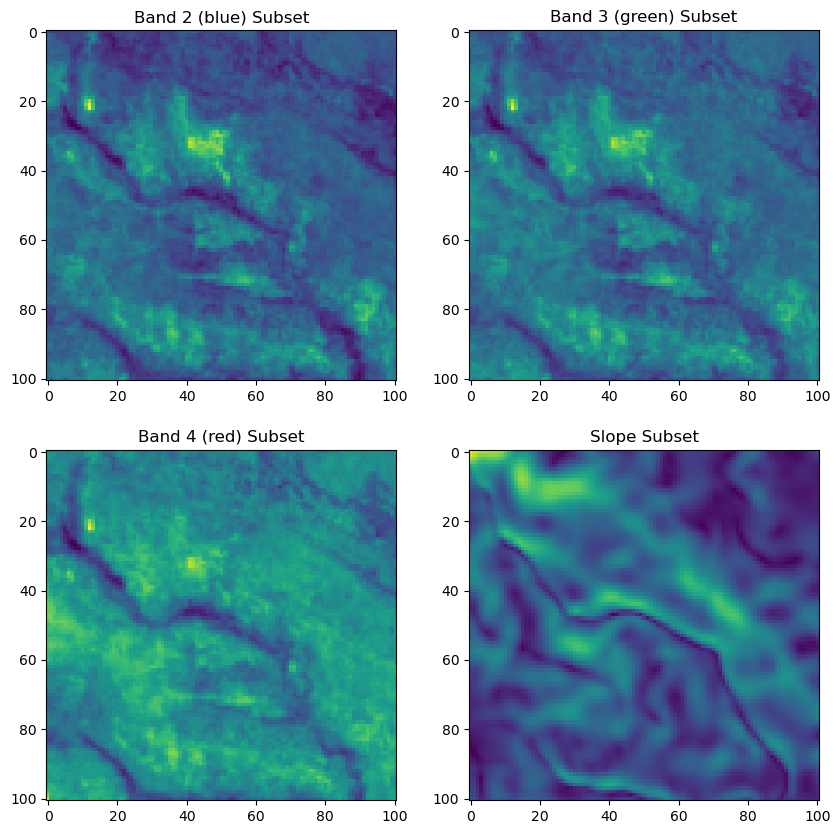

In [61]:
window_size = 101

# starting location of buffalo 2005
x = 41969.310875 
y = -1.435671e+06

yday = 280
month_index = day_to_month_index(yday)

# for sentinel 2 data
selected_month = f'2019_{month_index:02d}'
# Get the normalized data for the selected month
s2_data = data_dict[selected_month]

# Convert the NumPy array to a PyTorch tensor
s2_tensor = torch.from_numpy(s2_data)
s2_tensor = s2_tensor.float()  # Ensure the tensor is of type float
print(s2_tensor.shape)

s2_b1_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[0,:,:], x, y, window_size, raster_transform)
s2_b2_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[1,:,:], x, y, window_size, raster_transform)
s2_b3_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[2,:,:], x, y, window_size, raster_transform)
s2_b4_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[3,:,:], x, y, window_size, raster_transform)
s2_b5_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[4,:,:], x, y, window_size, raster_transform)
s2_b6_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[5,:,:], x, y, window_size, raster_transform)
s2_b7_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[6,:,:], x, y, window_size, raster_transform)
s2_b8_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[7,:,:], x, y, window_size, raster_transform)
s2_b8a_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[8,:,:], x, y, window_size, raster_transform)
s2_b9_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[9,:,:], x, y, window_size, raster_transform)
s2_b11_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[10,:,:], x, y, window_size, raster_transform)
s2_b12_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[11,:,:], x, y, window_size, raster_transform)

slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, raster_transform)

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(s2_b2_subset.numpy(), cmap='viridis')
axs[0, 0].set_title('Band 2 (blue) Subset')
# axs[0, 0].axis('off')

axs[0, 1].imshow(s2_b3_subset.numpy(), cmap='viridis')
axs[0, 1].set_title('Band 3 (green) Subset')
# # axs[0, 1].axis('off')

axs[1, 0].imshow(s2_b4_subset.numpy(), cmap='viridis')
axs[1, 0].set_title('Band 4 (red) Subset')
# # axs[1, 0].axis('off')

axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope Subset')
# axs[1, 1].axis('off')


# Next-step probability values

In [62]:
# test_data = buffalo_df.iloc[0:10]
test_data = buffalo_df
n = len(test_data)
# n = 4

# create empty vectors to store the predicted probabilities
habitat_probs = np.repeat(0., len(buffalo_df))
move_probs = np.repeat(0., len(buffalo_df))
next_step_probs = np.repeat(0., len(buffalo_df))

# start at 1 so the bearing at t - 1 is available
for i in range(1, n):
  
  sample_tm1 = test_data.iloc[i-1] # get the step at t - 1 for the bearing of the approaching step
  sample = test_data.iloc[i]

  # current location (x1, y1)
  x = sample['x1_']
  y = sample['y1_']
  # print('x and y are ', x,y)

  # Convert geographic coordinates to pixel coordinates
  px, py = ~raster_transform * (x, y)
  # Convert geographic coordinates to pixel coordinates
  # new_x, new_y = raster_transform * (px, py)
  # print('px and py are ', px, py)

  # next step location (x2, y2)
  x2 = sample['x2_']
  y2 = sample['y2_']
  # print('x2 and y2 are ', x2, y2)

  # Convert geographic coordinates to pixel coordinates
  px2, py2 = ~raster_transform * (x2, y2)
  # print('px2 and py2 are ', px2, py2)


  # # THE Y COORDINATE COMES FIRST in the sampled coordinates
  # new_px = origin_xs[0] + sampled_coordinates[1]
  # new_py = origin_ys[0] + sampled_coordinates[0]

  # # Convert geographic coordinates to pixel coordinates
  # new_x, new_y = raster_transform * (new_px, new_py)

  d_x = x2 - x
  d_y = y2 - y
  # print('d_x and d_y are ', d_x, d_y)
  

  # temporal covariates
  hour_t2_sin = sample['hour_t2_sin']
  hour_t2_cos = sample['hour_t2_cos']
  yday_t2_sin = sample['yday_t2_sin']
  yday_t2_cos = sample['yday_t2_cos']
  # print(hour_t2_sin, hour_t2_cos, yday_t2_sin, yday_t2_cos)

  # bearing of PREVIOUS step
  bearing = sample_tm1['bearing']
  # print(bearing)

  # yday = sample['yday_t2_base_2018']
  yday = sample['yday_t2']
  # print(yday)

  month_index = day_to_month_index(yday)
  # print(month_index)

  # for sentinel 2 data
  selected_month = f'2019_{month_index:02d}'
  # Get the normalized data for the selected month
  s2_data = data_dict[selected_month]

  # Convert the NumPy array to a PyTorch tensor
  s2_tensor = torch.from_numpy(s2_data)
  s2_tensor = s2_tensor.float()  # Ensure the tensor is of type float
  # print(s2_tensor.shape)

  s2_b1_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[0,:,:], x, y, window_size, raster_transform)
  s2_b2_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[1,:,:], x, y, window_size, raster_transform)
  s2_b3_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[2,:,:], x, y, window_size, raster_transform)
  s2_b4_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[3,:,:], x, y, window_size, raster_transform)
  s2_b5_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[4,:,:], x, y, window_size, raster_transform)
  s2_b6_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[5,:,:], x, y, window_size, raster_transform)
  s2_b7_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[6,:,:], x, y, window_size, raster_transform)
  s2_b8_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[7,:,:], x, y, window_size, raster_transform)
  s2_b8a_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[8,:,:], x, y, window_size, raster_transform)
  s2_b9_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[9,:,:], x, y, window_size, raster_transform)
  s2_b11_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[10,:,:], x, y, window_size, raster_transform)
  s2_b12_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[11,:,:], x, y, window_size, raster_transform)

  slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, raster_transform)

  # print('origin_x and origin_y are ', origin_x, origin_y)

  px2_subset = px2 - origin_x
  py2_subset = py2 - origin_y
  # print('delta origin_x and origin_y are ', px2_subset, py2_subset)
  # print('delta origin_x and origin_y are ', int(px2_subset), int(py2_subset))

  # Extract the value of the covariates at the location of x2, y2
  # value = ndvi_subset.detach().cpu().numpy()[(int(py2_subset), int(px2_subset))]
  # # from the stack of local layers
  # ndvi_max = 0.8220
  # ndvi_min = -0.2772
  # # return to natural scale
  # value_natural = value * (ndvi_max - ndvi_min) + ndvi_min
  # print('Value natural scale = ', value_natural)
  

  # # Plot the subset
  # fig, axs = plt.subplots(2, 2, figsize=(10, 10))

  # axs[0, 0].imshow(s2_b2_subset.numpy(), cmap='viridis')
  # axs[0, 0].set_title('Band 2 (blue) Subset')
  # fig.colorbar(axs[0, 0].imshow(s2_b2_subset.numpy(), cmap='viridis'), ax=axs[0, 0], shrink=0.7)
  # # axs[0, 0].axis('off')

  # axs[0, 1].imshow(s2_b3_subset.numpy(), cmap='viridis')
  # axs[0, 1].set_title('Band 3 (green) Subset')
  # fig.colorbar(axs[0, 1].imshow(s2_b3_subset.numpy(), cmap='viridis'), ax=axs[0, 1], shrink=0.7)
  # # # axs[0, 1].axis('off')

  # axs[1, 0].imshow(s2_b4_subset.numpy(), cmap='viridis')
  # axs[1, 0].set_title('Band 4 (red) Subset')
  # fig.colorbar(axs[1, 0].imshow(s2_b4_subset.numpy(), cmap='viridis'), ax=axs[1, 0], shrink=0.7)
  # # # axs[1, 0].axis('off')

  # axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
  # axs[1, 1].set_title('Slope Subset')
  # fig.colorbar(axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis'), ax=axs[1, 1], shrink=0.7)
  # # axs[1, 1].axis('off')

  # Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
  x1 = torch.stack([s2_b1_subset,
                    s2_b2_subset, 
                    s2_b3_subset, 
                    s2_b4_subset, 
                    s2_b5_subset,
                    s2_b6_subset,
                    s2_b7_subset,
                    s2_b8_subset,
                    s2_b8a_subset,
                    s2_b9_subset,
                    s2_b11_subset,
                    s2_b12_subset,
                    slope_subset], dim=0)
  
  x1 = x1.unsqueeze(0)
  # print(x1.shape)

  # Convert lists to PyTorch tensors
  hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
  hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
  yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
  yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()

  # Stack tensors column-wise
  x2 = torch.stack((hour_t2_sin_tensor.unsqueeze(0), 
                    hour_t2_cos_tensor.unsqueeze(0), 
                    yday_t2_sin_tensor.unsqueeze(0), 
                    yday_t2_cos_tensor.unsqueeze(0)),  
                    dim=1)
  # print(x2)
  # print(x2.shape)

  # put bearing in the correct dimension (batch_size, 1)
  bearing = torch.tensor(bearing).float().unsqueeze(0).unsqueeze(0)
  # print(bearing)
  # print(bearing.shape)

  # run the model on the subsetted layers
  test = model((x1, x2, bearing))

  # plot the results of the habitat density as an image
  hab_density = test.detach().cpu().numpy()[0,:,:,0]
  hab_density_exp = np.exp(hab_density)
  # print(np.sum(hab_density_exp))

  # Store the probability of habitat selection at the location of x2, y2
  habitat_probs[i] = hab_density_exp[(int(py2_subset), int(px2_subset))]
  # print('Habitat probability value = ', habitat_probs[i])

  # Create the mask for x and y coordinates
  x_mask = np.ones_like(hab_density)
  y_mask = np.ones_like(hab_density)

  # mask out cells on the edges that affect the colour scale
  x_mask[:, :3] = -np.inf
  x_mask[:, 98:] = -np.inf
  y_mask[:3, :] = -np.inf
  y_mask[98:, :] = -np.inf

  hab_density_mask = hab_density * x_mask * y_mask
  hab_density_exp_mask = hab_density_exp * x_mask * y_mask

  # # plot the results of the habitat density as an image - in log scale
  # plt.imshow(hab_density_mask)
  # plt.colorbar()
  # plt.show()

  # # plot the results of the habitat density as an image - as probabilities
  # plt.imshow(hab_density_exp_mask)
  # plt.colorbar()
  # plt.show()

  # movement probability
  move_density = test.detach().cpu().numpy()[0,:,:,1]
  move_density_exp = np.exp(move_density)
  # print(np.sum(move_density_exp))

  # Store the probability of movement at the location of x2, y2
  move_probs[i] = move_density_exp[(int(py2_subset), int(px2_subset))]
  # print('Movement probability value = ', move_probs[i])

  move_density_mask = move_density * x_mask * y_mask
  move_density_exp_mask = move_density_exp * x_mask * y_mask

  # # plot the results of the movement density as an image - in log scale
  # plt.imshow(move_density_mask)
  # plt.colorbar()
  # plt.show()

  # # plot the results of the movement density as an image - as probabilities
  # plt.imshow(move_density_exp_mask)
  # plt.colorbar()
  # plt.show()

  # next step probability
  step_density = test[0, :, :, 0] + test[0, :, :, 1]
  step_density = step_density.detach().cpu().numpy()
  step_density_exp = np.exp(step_density)
  # print('Sum of step density exp = ', np.sum(step_density_exp))

  step_density_exp_norm = step_density_exp / np.sum(step_density_exp)
  # print('Sum of step density exp norm = ', np.sum(step_density_exp_norm))

  # Extract the value of the covariates at the location of x2, y2
  next_step_probs[i] = step_density_exp_norm[(int(py2_subset), int(px2_subset))]
  # print('Next-step probability value = ', next_step_probs[i])

  step_density_mask = step_density * x_mask * y_mask
  step_density_exp_norm_mask = step_density_exp_norm * x_mask * y_mask

  # # results of the habitat and movement densities
  # # log-scale
  # plt.imshow(step_density_mask)
  # plt.colorbar()
  # plt.show()

  # # exponentiated
  # plt.imshow(step_density_exp_mask)
  # plt.colorbar()
  # plt.show()



  # # Plot the outputs
  # fig_out, axs_out = plt.subplots(2, 2, figsize=(10, 10))

  # # RGB for plotting
  # # pull out the RGB bands
  # r_band = s2_b4_subset.detach().numpy()
  # g_band = s2_b3_subset.detach().numpy()
  # b_band = s2_b2_subset.detach().numpy()

  # # Stack the bands along a new axis
  # rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
  # # Normalize to the range [0, 1] for display
  # rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

  # # Plot s2_b2
  # im1 = axs_out[0, 0].imshow(rgb_image)
  # axs_out[0, 0].set_title('Sentinel 2 RGB')
  # # fig_out.colorbar(im1, ax=axs_out[0, 0], shrink=0.7)

  # # # Plot target
  # # im2 = axs[0, 1].imshow(labels.detach().cpu().numpy()[0,:,:], cmap='viridis')
  # # axs[0, 1].set_title('Observed next step')
  # # # fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

  # # # Plot slope
  # # im2 = axs[0, 1].imshow(x1.detach().cpu().numpy()[0,12,:,:], cmap='viridis')
  # # axs[0, 1].set_title('Slope')
  # # fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

  # # Plot habitat selection log-probability
  # im2 = axs_out[0, 1].imshow(hab_density_mask, cmap='viridis')
  # axs_out[0, 1].set_title('Habitat selection log-probability')
  # fig_out.colorbar(im2, ax=axs_out[0, 1], shrink=0.7)

  # # Movement density log-probability
  # im3 = axs_out[1, 0].imshow(move_density_mask, cmap='viridis')
  # axs_out[1, 0].set_title('Movement log-probability')
  # fig_out.colorbar(im3, ax=axs_out[1, 0], shrink=0.7)

  # # # Next-step log probability
  # # im4 = axs[1, 1].imshow(step_density_mask, cmap='viridis')
  # # axs[1, 1].set_title('Next-step log-probability')
  # # fig.colorbar(im4, ax=axs[1, 1], shrink=0.7)

  # # [(int(py2_subset), int(px2_subset))]
  # next_step_mask = np.ones_like(hab_density)
  # next_step_mask[int(py2_subset), int(px2_subset)] = -np.inf

  # # Next-step probability
  # im4 = axs_out[1, 1].imshow(step_density_exp_norm_mask * next_step_mask, cmap='viridis')
  # axs_out[1, 1].set_title('Next-step probability')
  # fig_out.colorbar(im4, ax=axs_out[1, 1], shrink=0.7)

  # # filename_covs = f'outputs/next_step_validation/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}.png'
  # # plt.tight_layout()
  # # plt.savefig(filename_covs, dpi=600, bbox_inches='tight')
  # # plt.show()
  # # plt.close()  # Close the figure to free memory

In [63]:
print(next_step_probs)

[0.00000000e+00 3.24961298e-03 5.54401817e-03 ... 8.63930943e-01
 1.09650402e-04 8.40177505e-05]


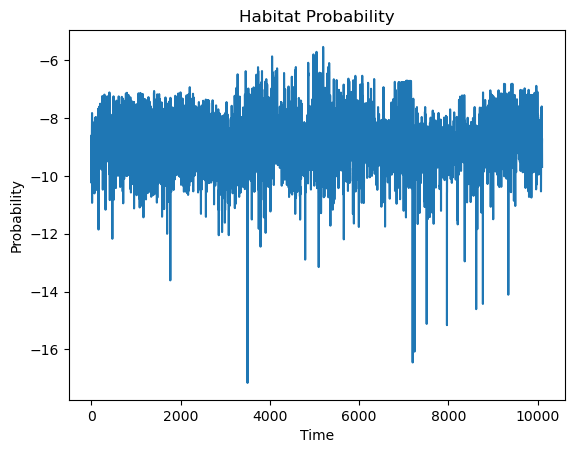

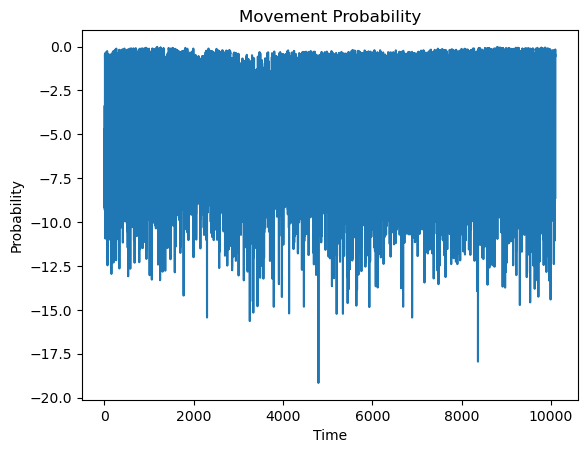

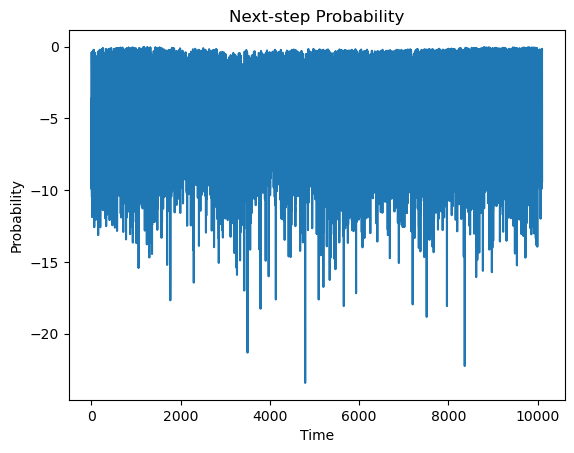

In [64]:
# Plot the habitat probs through time as a line graph
plt.plot(np.log(habitat_probs[habitat_probs>0]))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Habitat Probability')
plt.show()

# Plot the movement probs through time as a line graph
plt.plot(np.log(move_probs[move_probs>0]))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Movement Probability')
plt.show()

# Plot the next_step probs through time as a line graph
plt.plot(np.log(next_step_probs[next_step_probs>0]))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Next-step Probability')
plt.show()


In [65]:
# Append the probabilities to the dataframe
buffalo_df['habitat_probs'] = habitat_probs
buffalo_df['move_probs'] = move_probs
buffalo_df['next_step_probs'] = next_step_probs

In [66]:
csv_filename = f'../outputs/next_step_probs_S2_id{buffalo_id}_{today_date}.csv'

print(csv_filename)
buffalo_df.to_csv(csv_filename, index=True)

../outputs/next_step_probs_S2_id2005_2025-01-03.csv


# Loop the validation over each individual

In [67]:
# select the id to train the model on
# buffalo_id = 2005
# n_samples = 10297

# buffalo_id = 2014
# n_samples = 6572

# buffalo_id = 2327
# n_samples = 8983

# buffalo_id = 2387
# n_samples = 10409

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/validation/validation_buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

# Lag the values in column 'A' by one index
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

         ta    cos_ta         x_min         x_max         y_min         y_max  \
0  1.367942  0.20

In [68]:
# Step 1: Specify the directory containing your TIFF files
data_dir = '../buffalo_local_data_id/validation'  # Replace with the actual path to your TIFF files

# Step 2: Use glob to get a list of all TIFF files matching the pattern
csv_files = glob.glob(os.path.join(data_dir, 'validation_*.csv')) 
print(f'Found {len(csv_files)} CSV files')
print('\n'.join(csv_files))

Found 13 CSV files
../buffalo_local_data_id/validation\validation_buffalo_2005_data_df_lag_1hr_n10297.csv
../buffalo_local_data_id/validation\validation_buffalo_2014_data_df_lag_1hr_n6572.csv
../buffalo_local_data_id/validation\validation_buffalo_2018_data_df_lag_1hr_n9440.csv
../buffalo_local_data_id/validation\validation_buffalo_2021_data_df_lag_1hr_n6928.csv
../buffalo_local_data_id/validation\validation_buffalo_2022_data_df_lag_1hr_n9099.csv
../buffalo_local_data_id/validation\validation_buffalo_2024_data_df_lag_1hr_n9531.csv
../buffalo_local_data_id/validation\validation_buffalo_2039_data_df_lag_1hr_n5569.csv
../buffalo_local_data_id/validation\validation_buffalo_2154_data_df_lag_1hr_n10417.csv
../buffalo_local_data_id/validation\validation_buffalo_2158_data_df_lag_1hr_n9700.csv
../buffalo_local_data_id/validation\validation_buffalo_2223_data_df_lag_1hr_n5310.csv
../buffalo_local_data_id/validation\validation_buffalo_2327_data_df_lag_1hr_n8983.csv
../buffalo_local_data_id/validati

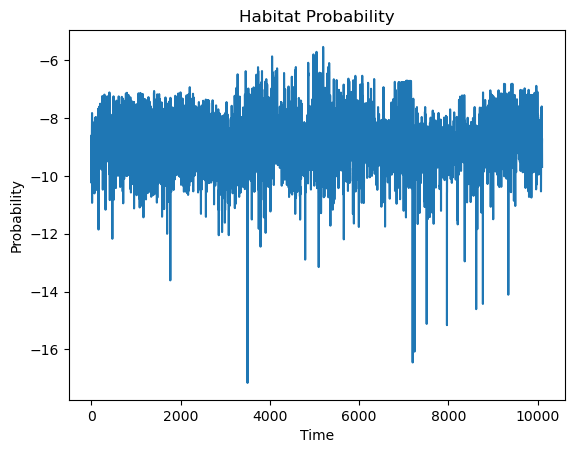

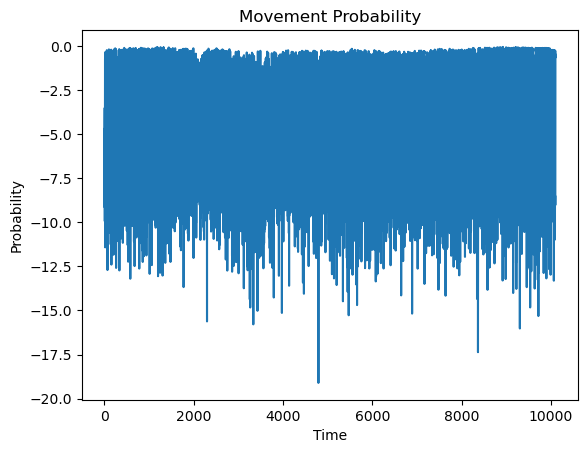

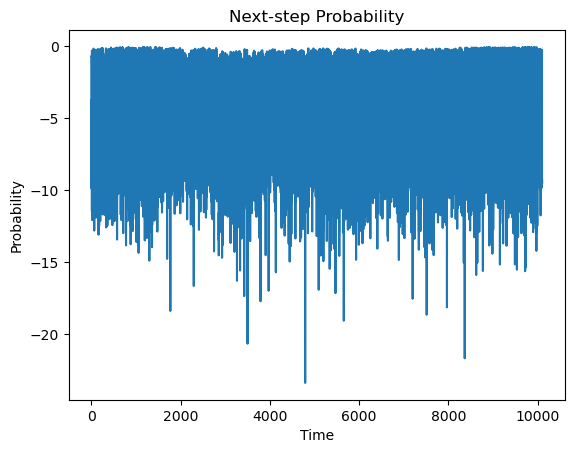

../outputs/next_step_probs_S2_id2005_2025-01-03.csv


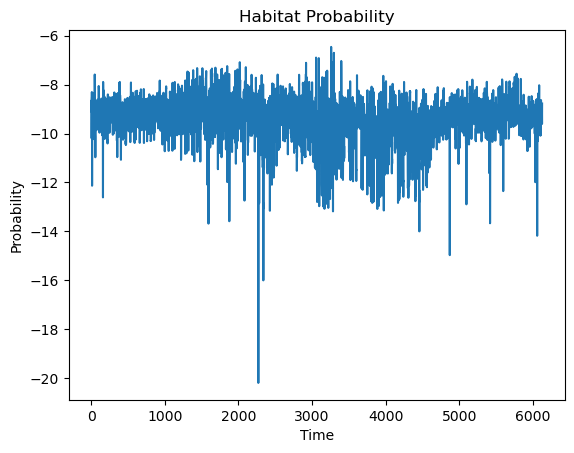

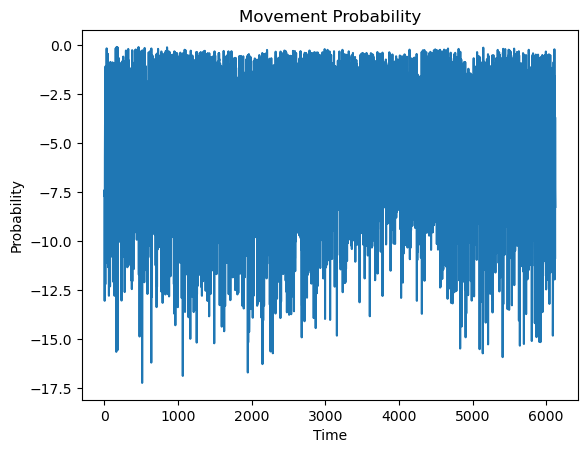

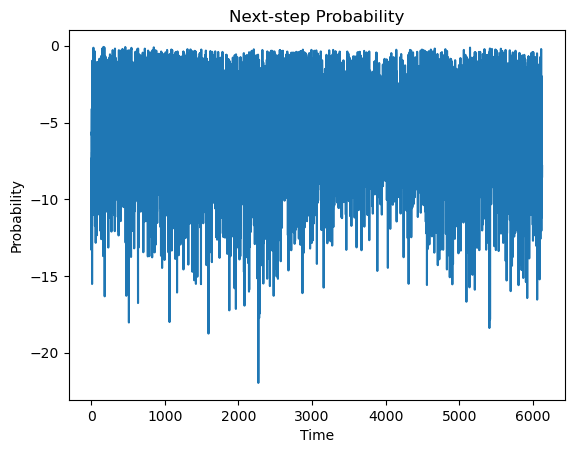

../outputs/next_step_probs_S2_id2014_2025-01-03.csv


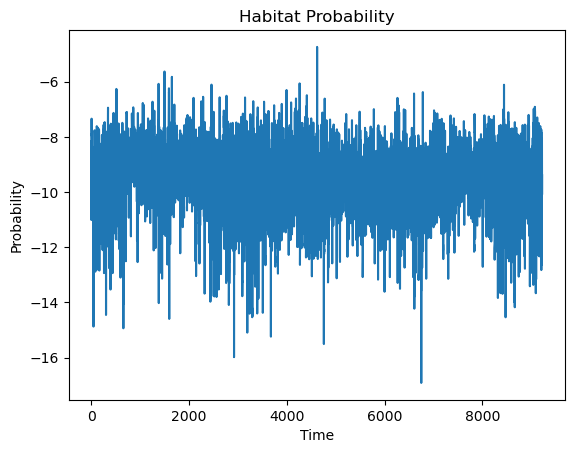

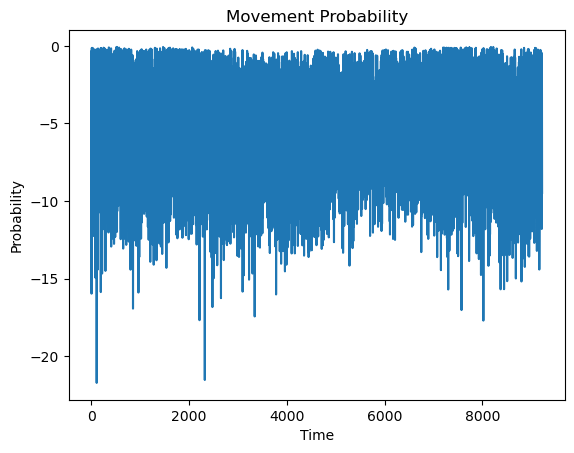

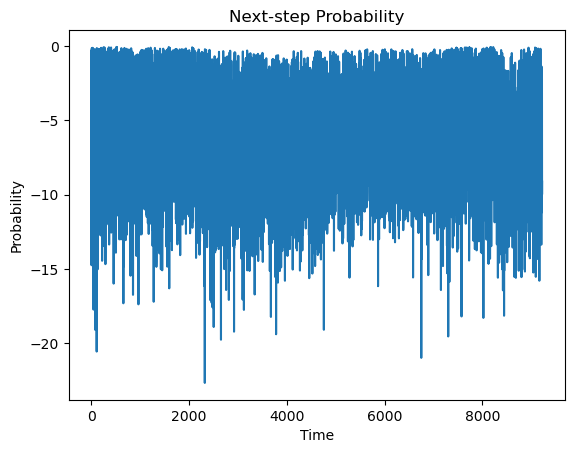

../outputs/next_step_probs_S2_id2018_2025-01-03.csv


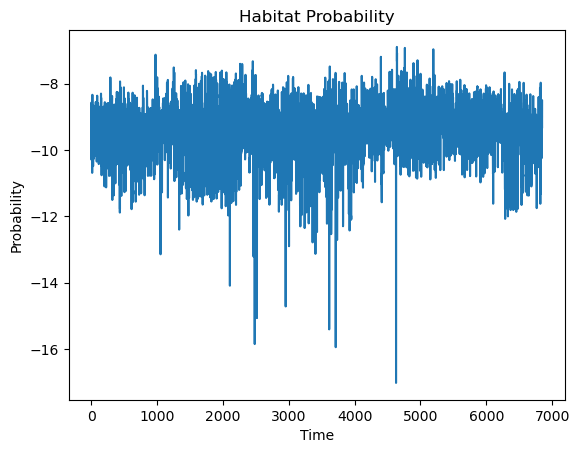

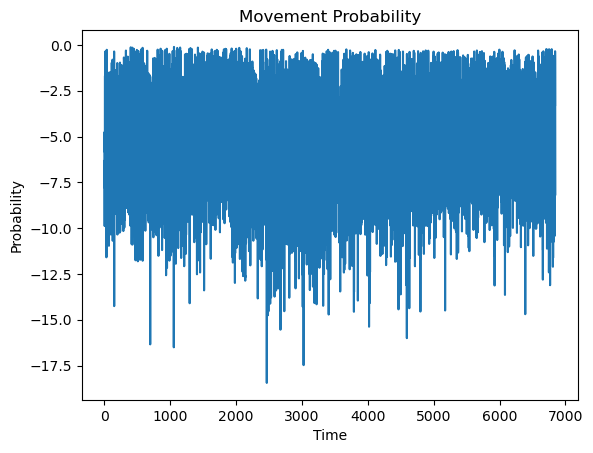

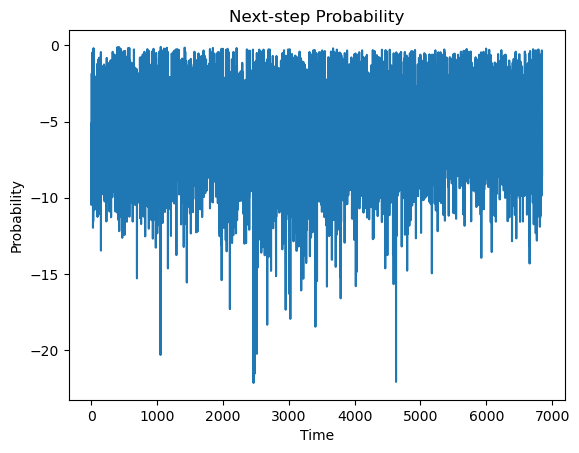

../outputs/next_step_probs_S2_id2021_2025-01-03.csv


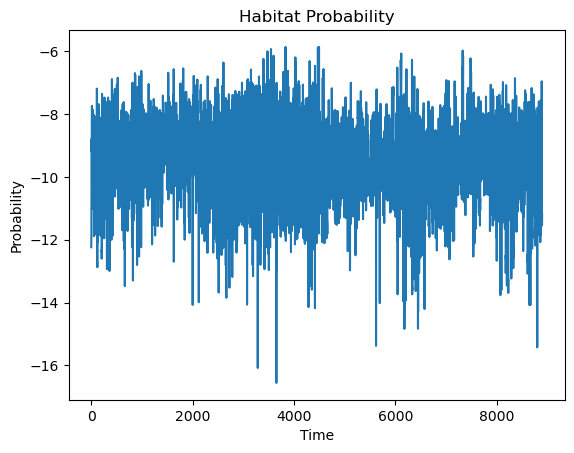

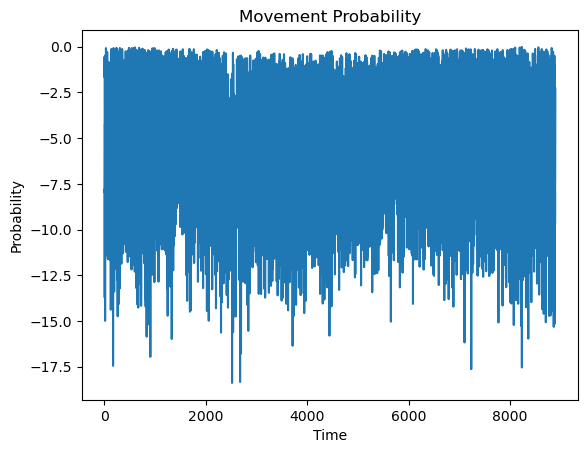

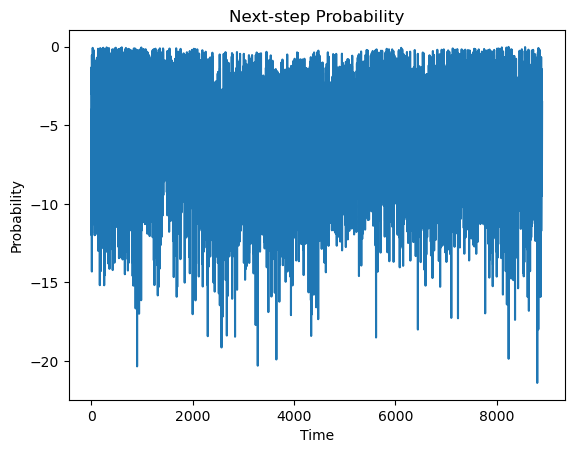

../outputs/next_step_probs_S2_id2022_2025-01-03.csv


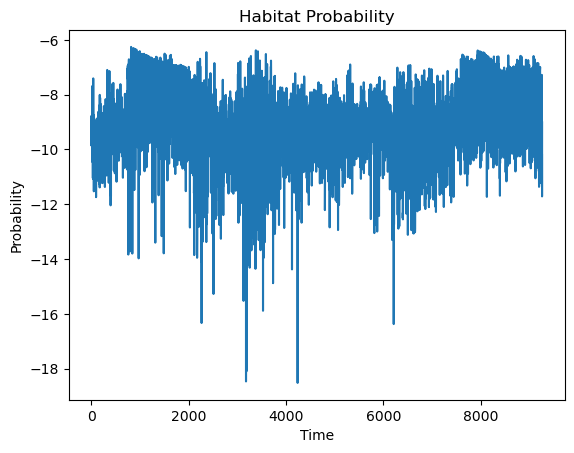

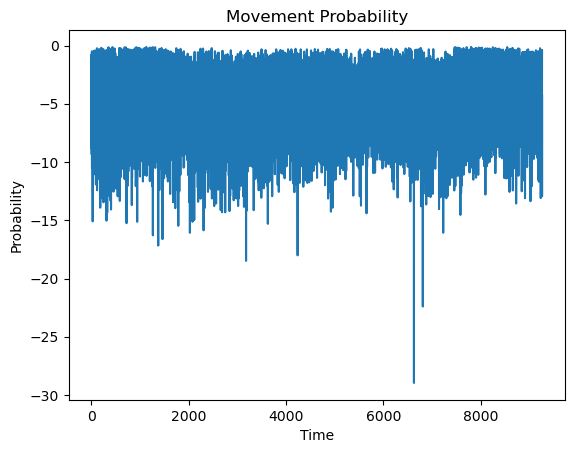

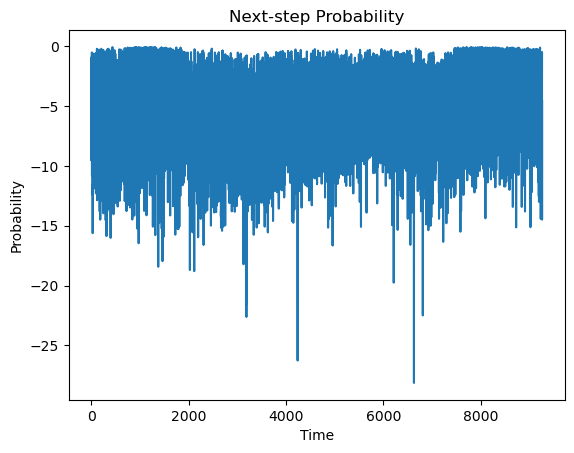

../outputs/next_step_probs_S2_id2024_2025-01-03.csv


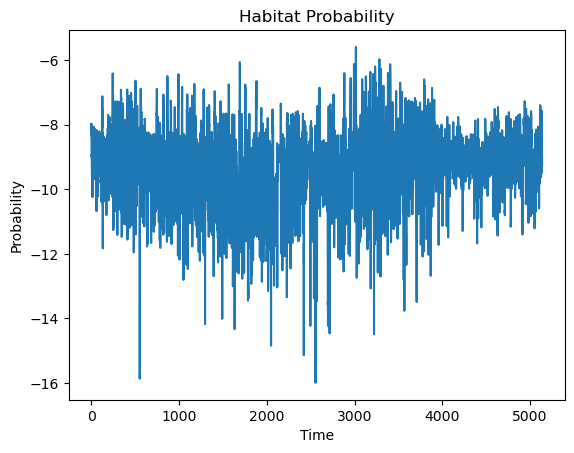

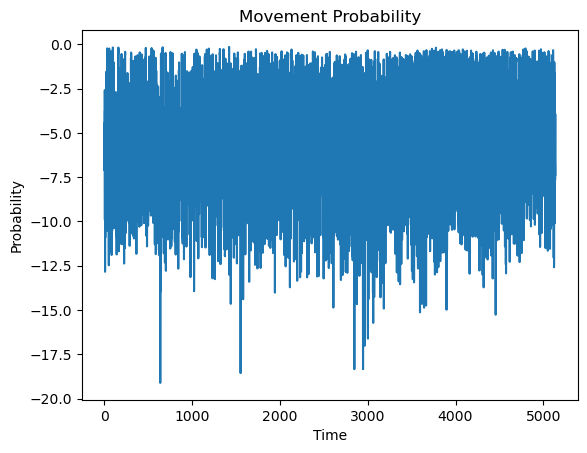

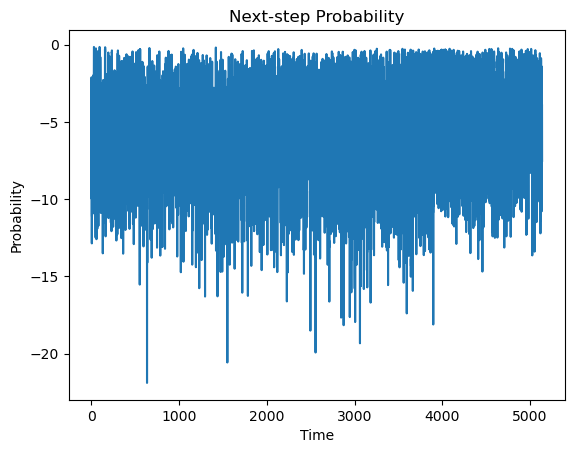

../outputs/next_step_probs_S2_id2039_2025-01-03.csv


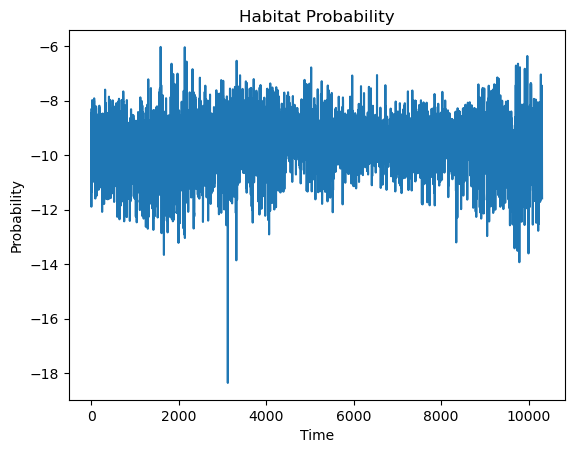

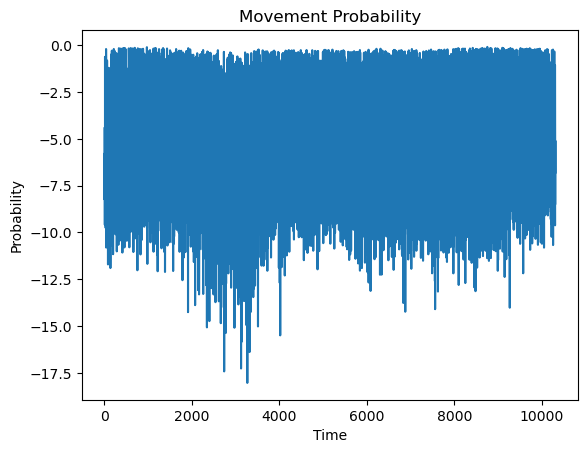

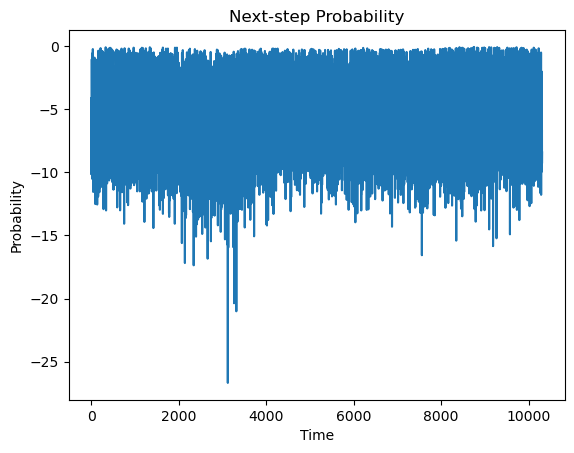

../outputs/next_step_probs_S2_id2154_2025-01-03.csv


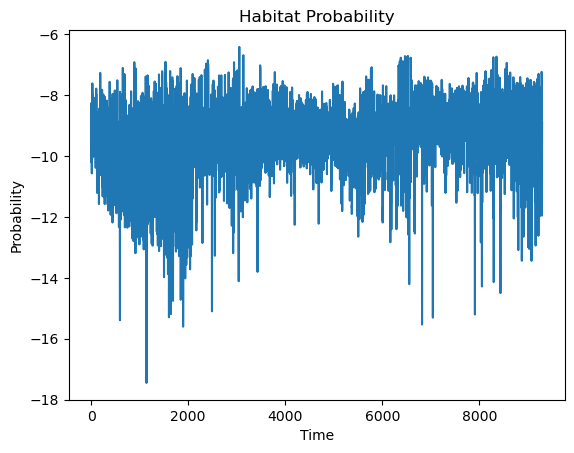

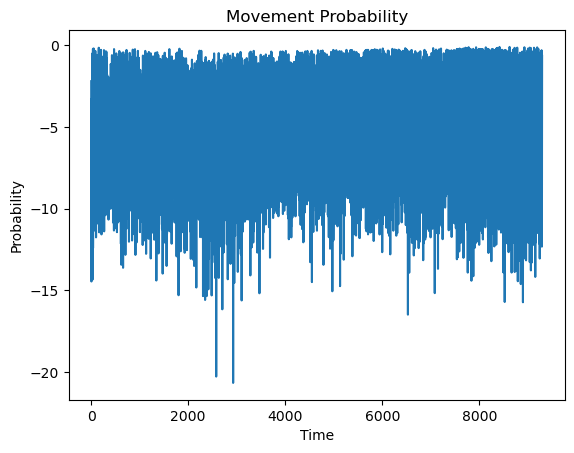

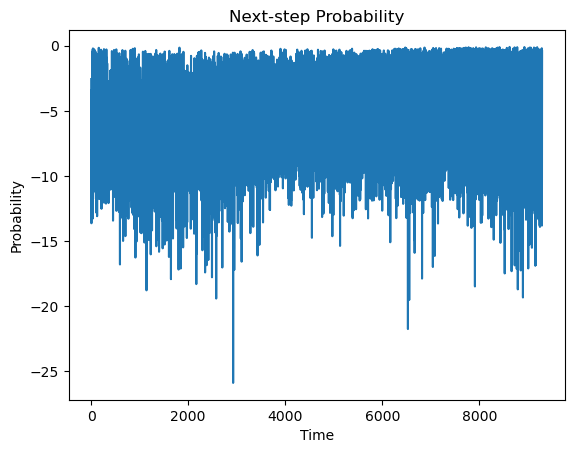

../outputs/next_step_probs_S2_id2158_2025-01-03.csv


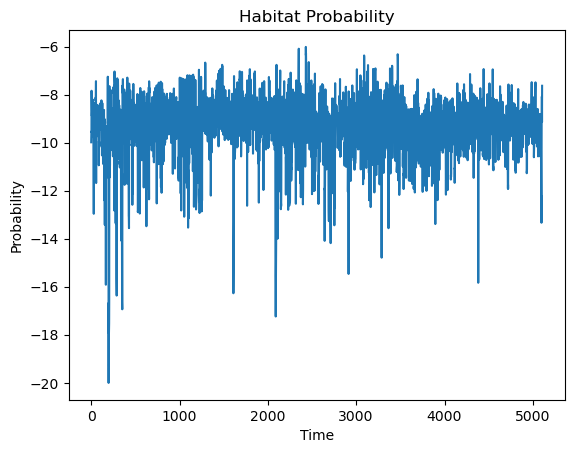

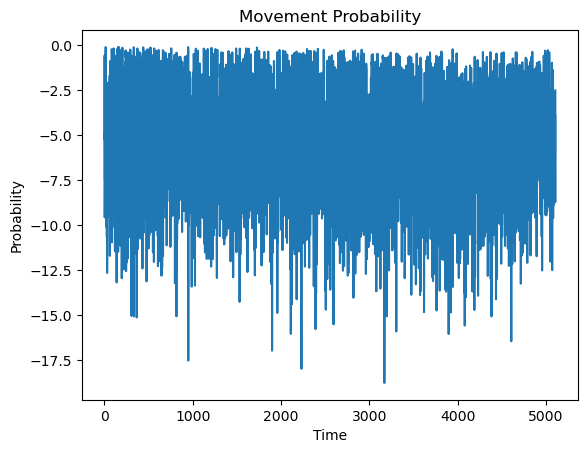

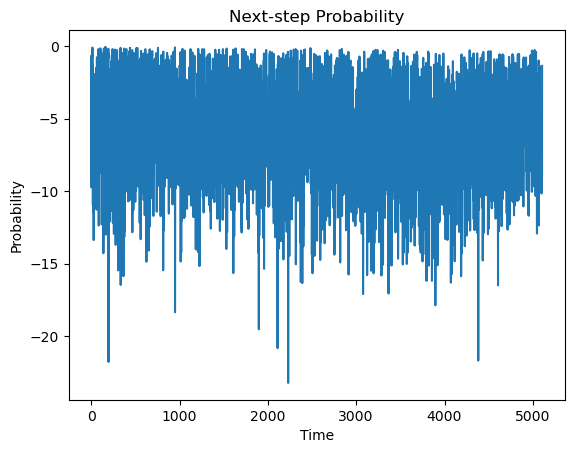

../outputs/next_step_probs_S2_id2223_2025-01-03.csv


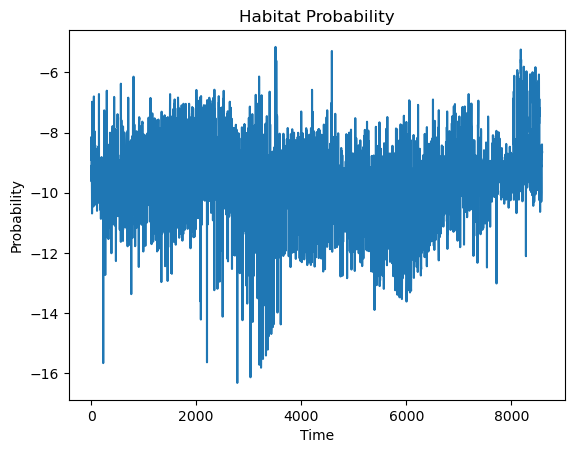

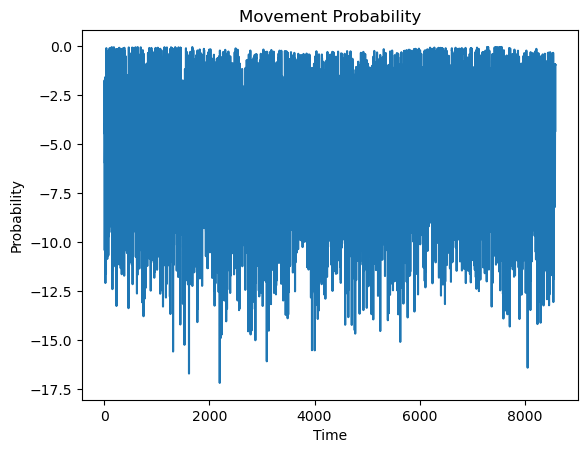

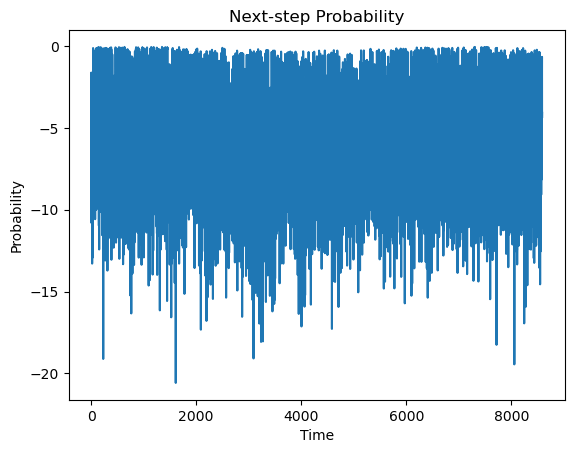

../outputs/next_step_probs_S2_id2327_2025-01-03.csv


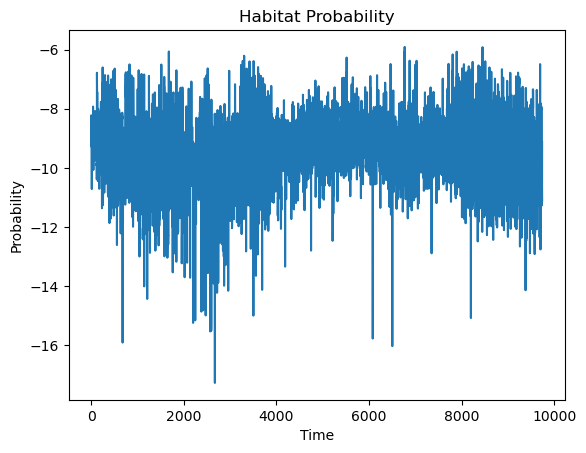

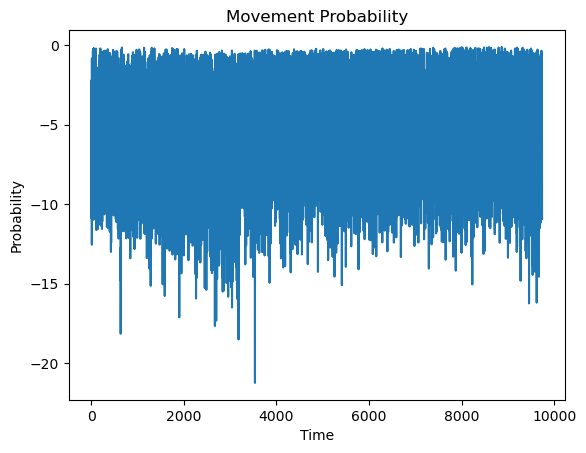

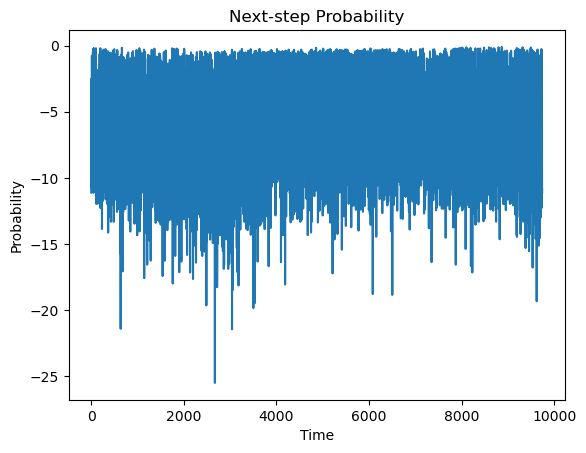

../outputs/next_step_probs_S2_id2387_2025-01-03.csv


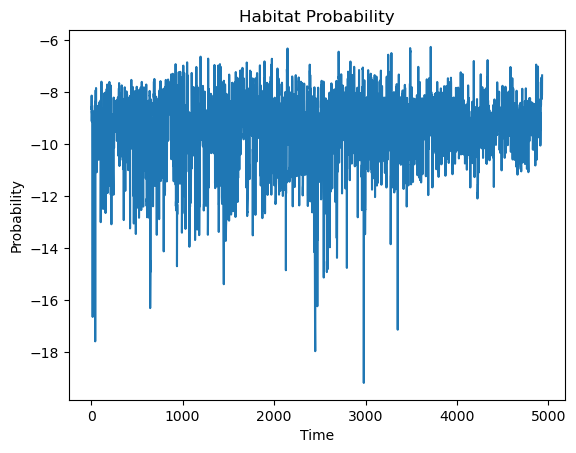

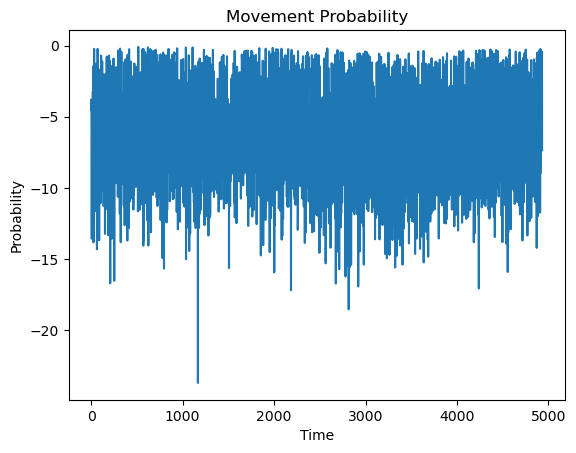

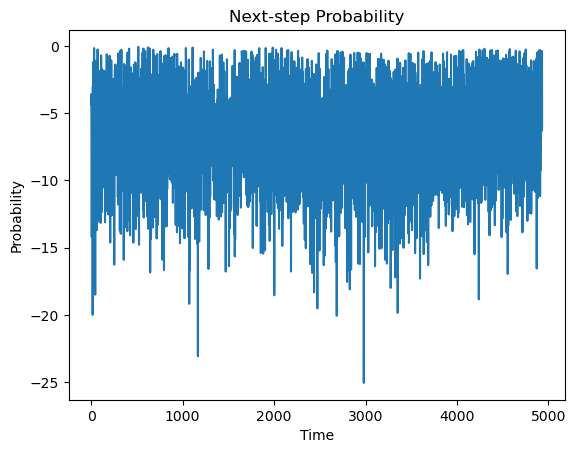

../outputs/next_step_probs_S2_id2393_2025-01-03.csv


In [72]:
for j in range(0, len(csv_files)):

    # Read the CSV file into a DataFrame
    buffalo_df = pd.read_csv(csv_files[j])

    # for saving the file
    buffalo_id = csv_files[j][55:59]

    # Display the first few rows of the DataFrame
    # print(buffalo_df.head())

    # Lag the values in column 'A' by one index
    buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
    # Pad the missing value with a specified value, e.g., 0
    buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

    # test_data = buffalo_df.iloc[0:10]
    test_data = buffalo_df
    n = len(test_data)

    # create empty vectors to store the predicted probabilities
    habitat_probs = np.repeat(0., len(buffalo_df))
    move_probs = np.repeat(0., len(buffalo_df))
    next_step_probs = np.repeat(0., len(buffalo_df))

    # start at 1 so the bearing at t - 1 is available
    for i in range(1, n):
    
        sample_tm1 = test_data.iloc[i-1] # get the step at t - 1 for the bearing of the approaching step
        sample = test_data.iloc[i]

        # current location (x1, y1)
        x = sample['x1_']
        y = sample['y1_']
        # print('x and y are ', x,y)

        # Convert geographic coordinates to pixel coordinates
        px, py = ~raster_transform * (x, y)
        # Convert geographic coordinates to pixel coordinates
        # new_x, new_y = raster_transform * (px, py)
        # print('px and py are ', px, py)

        # next step location (x2, y2)
        x2 = sample['x2_']
        y2 = sample['y2_']
        # print('x2 and y2 are ', x2, y2)

        # Convert geographic coordinates to pixel coordinates
        px2, py2 = ~raster_transform * (x2, y2)
        # print('px2 and py2 are ', px2, py2)


        # # THE Y COORDINATE COMES FIRST in the sampled coordinates
        # new_px = origin_xs[0] + sampled_coordinates[1]
        # new_py = origin_ys[0] + sampled_coordinates[0]

        # # Convert geographic coordinates to pixel coordinates
        # new_x, new_y = raster_transform * (new_px, new_py)

        d_x = x2 - x
        d_y = y2 - y
        # print('d_x and d_y are ', d_x, d_y)
        

        # temporal covariates
        hour_t2_sin = sample['hour_t2_sin']
        hour_t2_cos = sample['hour_t2_cos']
        yday_t2_sin = sample['yday_t2_sin']
        yday_t2_cos = sample['yday_t2_cos']
        # print(hour_t2_sin, hour_t2_cos, yday_t2_sin, yday_t2_cos)

        # bearing of PREVIOUS step
        bearing = sample_tm1['bearing']
        # print(bearing)

        yday = sample['yday_t2_2018_base']
        # yday = sample['yday_t2']
        # print(yday)

        month_index = day_to_month_index(yday)
        # print(month_index)

        # Adjust month_index to range from 1 to 12
        month_index = (month_index - 1) % 12 + 1

        # for sentinel 2 data
        selected_month = f'2019_{month_index:02d}'
        # Get the normalized data for the selected month
        s2_data = data_dict[selected_month]

        # Convert the NumPy array to a PyTorch tensor
        s2_tensor = torch.from_numpy(s2_data)
        s2_tensor = s2_tensor.float()  # Ensure the tensor is of type float
        # print(s2_tensor.shape)

        s2_b1_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[0,:,:], x, y, window_size, raster_transform)
        s2_b2_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[1,:,:], x, y, window_size, raster_transform)
        s2_b3_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[2,:,:], x, y, window_size, raster_transform)
        s2_b4_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[3,:,:], x, y, window_size, raster_transform)
        s2_b5_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[4,:,:], x, y, window_size, raster_transform)
        s2_b6_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[5,:,:], x, y, window_size, raster_transform)
        s2_b7_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[6,:,:], x, y, window_size, raster_transform)
        s2_b8_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[7,:,:], x, y, window_size, raster_transform)
        s2_b8a_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[8,:,:], x, y, window_size, raster_transform)
        s2_b9_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[9,:,:], x, y, window_size, raster_transform)
        s2_b11_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[10,:,:], x, y, window_size, raster_transform)
        s2_b12_subset, origin_x, origin_y = subset_raster_with_padding_torch(s2_tensor[11,:,:], x, y, window_size, raster_transform)

        slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, raster_transform)

        # Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
        x1 = torch.stack([s2_b1_subset,
                            s2_b2_subset, 
                            s2_b3_subset, 
                            s2_b4_subset, 
                            s2_b5_subset,
                            s2_b6_subset,
                            s2_b7_subset,
                            s2_b8_subset,
                            s2_b8a_subset,
                            s2_b9_subset,
                            s2_b11_subset,
                            s2_b12_subset,
                            slope_subset], dim=0)
        
        x1 = x1.unsqueeze(0)
        # print(x1.shape)

        # print('origin_x and origin_y are ', origin_x, origin_y)

        px2_subset = px2 - origin_x
        py2_subset = py2 - origin_y
        # print('delta origin_x and origin_y are ', px2_subset, py2_subset)
        # print('delta origin_x and origin_y are ', int(px2_subset), int(py2_subset))

        # Convert lists to PyTorch tensors
        hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
        hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
        yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
        yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()

        # Stack tensors column-wise
        x2 = torch.stack((hour_t2_sin_tensor.unsqueeze(0), 
                            hour_t2_cos_tensor.unsqueeze(0), 
                            yday_t2_sin_tensor.unsqueeze(0), 
                            yday_t2_cos_tensor.unsqueeze(0)),  
                            dim=1)
        # print(x2)
        # print(x2.shape)

        # put bearing in the correct dimension (batch_size, 1)
        bearing = torch.tensor(bearing).float().unsqueeze(0).unsqueeze(0)
        # print(bearing)
        # print(bearing.shape)

        test = model((x1, x2, bearing))

        # plot the results of the habitat density as an image
        hab_density = test.detach().cpu().numpy()[0,:,:,0]
        hab_density_exp = np.exp(hab_density)
        # print(np.sum(hab_density_exp))

        # Store the probability of habitat selection at the location of x2, y2
        habitat_probs[i] = hab_density_exp[(int(py2_subset), int(px2_subset))]
        # print('Habitat probability value = ', habitat_probs[i])

        # Create the mask for x and y coordinates
        x_mask = np.ones_like(hab_density)
        y_mask = np.ones_like(hab_density)

        # mask out cells on the edges that affect the colour scale
        x_mask[:, :3] = -np.inf
        x_mask[:, 98:] = -np.inf
        y_mask[:3, :] = -np.inf
        y_mask[98:, :] = -np.inf

        hab_density_mask = hab_density * x_mask * y_mask
        hab_density_exp_mask = hab_density_exp * x_mask * y_mask

        # # plot the results of the habitat density as an image - in log scale
        # plt.imshow(hab_density_mask)
        # plt.colorbar()
        # plt.show()

        # # plot the results of the habitat density as an image - as probabilities
        # plt.imshow(hab_density_exp_mask)
        # plt.colorbar()
        # plt.show()

        # movement probability
        move_density = test.detach().cpu().numpy()[0,:,:,1]
        move_density_exp = np.exp(move_density)
        # print(np.sum(move_density_exp))

        # Store the probability of movement at the location of x2, y2
        move_probs[i] = move_density_exp[(int(py2_subset), int(px2_subset))]
        # print('Movement probability value = ', move_probs[i])

        move_density_mask = move_density * x_mask * y_mask
        move_density_exp_mask = move_density_exp * x_mask * y_mask

        # # plot the results of the movement density as an image - in log scale
        # plt.imshow(move_density_mask)
        # plt.colorbar()
        # plt.show()

        # # plot the results of the movement density as an image - as probabilities
        # plt.imshow(move_density_exp_mask)
        # plt.colorbar()
        # plt.show()

        # next step probability
        step_density = test[0, :, :, 0] + test[0, :, :, 1]
        step_density = step_density.detach().cpu().numpy()
        step_density_exp = np.exp(step_density)
        # print('Sum of step density exp = ', np.sum(step_density_exp))

        step_density_exp_norm = step_density_exp / np.sum(step_density_exp)
        # print('Sum of step density exp norm = ', np.sum(step_density_exp_norm))

        # Extract the value of the covariates at the location of x2, y2
        next_step_probs[i] = step_density_exp_norm[(int(py2_subset), int(px2_subset))]
        # print('Next-step probability value = ', next_step_probs[i])

        step_density_mask = step_density * x_mask * y_mask
        step_density_exp_norm_mask = step_density_exp_norm * x_mask * y_mask

        # # results of the habitat and movement densities
        # # log-scale
        # plt.imshow(step_density_mask)
        # plt.colorbar()
        # plt.show()

        # # exponentiated
        # plt.imshow(step_density_exp_mask)
        # plt.colorbar()
        # plt.show()


        # # Plot the outputs
        # fig_out, axs_out = plt.subplots(2, 2, figsize=(10, 10))

        # # Plot NDVI
        # im1 = axs_out[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
        # axs_out[0, 0].set_title('NDVI')
        # fig_out.colorbar(im1, ax=axs_out[0, 0], shrink=0.7)

        # # # Plot target
        # # im2 = axs[0, 1].imshow(labels.detach().cpu().numpy()[0,:,:], cmap='viridis')
        # # axs[0, 1].set_title('Observed next step')
        # # # fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

        # # # Plot slope
        # # im2 = axs[0, 1].imshow(x1.detach().cpu().numpy()[0,12,:,:], cmap='viridis')
        # # axs[0, 1].set_title('Slope')
        # # fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

        # # Plot habitat selection log-probability
        # im2 = axs_out[0, 1].imshow(hab_density_mask, cmap='viridis')
        # axs_out[0, 1].set_title('Habitat selection log-probability')
        # fig_out.colorbar(im2, ax=axs_out[0, 1], shrink=0.7)

        # # Movement density log-probability
        # im3 = axs_out[1, 0].imshow(move_density_mask, cmap='viridis')
        # axs_out[1, 0].set_title('Movement log-probability')
        # fig_out.colorbar(im3, ax=axs_out[1, 0], shrink=0.7)

        # # # Next-step log probability
        # # im4 = axs[1, 1].imshow(step_density_mask, cmap='viridis')
        # # axs[1, 1].set_title('Next-step log-probability')
        # # fig.colorbar(im4, ax=axs[1, 1], shrink=0.7)

        # # [(int(py2_subset), int(px2_subset))]
        # next_step_mask = np.ones_like(hab_density)
        # next_step_mask[int(py2_subset), int(px2_subset)] = -np.inf

        # # Next-step probability
        # im4 = axs_out[1, 1].imshow(step_density_exp_norm_mask * next_step_mask, cmap='viridis')
        # axs_out[1, 1].set_title('Next-step probability')
        # fig_out.colorbar(im4, ax=axs_out[1, 1], shrink=0.7)

        # # filename_covs = f'outputs/next_step_validation/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}.png'
        # # plt.tight_layout()
        # # plt.savefig(filename_covs, dpi=600, bbox_inches='tight')
        # # plt.show()
        # # plt.close()  # Close the figure to free memory

        
    # Plot the habitat probs through time as a line graph
    plt.plot(np.log(habitat_probs[habitat_probs>0]))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.title('Habitat Probability')
    plt.show()

    # Plot the movement probs through time as a line graph
    plt.plot(np.log(move_probs[move_probs>0]))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.title('Movement Probability')
    plt.show()

    # Plot the next_step probs through time as a line graph
    plt.plot(np.log(next_step_probs[next_step_probs>0]))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.title('Next-step Probability')
    plt.show()

    # Append the probabilities to the dataframe
    buffalo_df['habitat_probs'] = habitat_probs
    buffalo_df['move_probs'] = move_probs
    buffalo_df['next_step_probs'] = next_step_probs
    csv_filename = f'../outputs/next_step_probs_S2_id{buffalo_id}_{today_date}.csv'

    print(csv_filename)
    buffalo_df.to_csv(csv_filename, index=True)

In [64]:
buffalo_df

x_            y_                    t_    id           x1_  \
0     32550.348534 -1.423005e+06  2018-07-25T02:11:31Z  2393  32550.348534   
1     32550.671636 -1.423009e+06  2018-07-25T03:10:28Z  2393  32550.671636   
2     32549.540847 -1.423008e+06  2018-07-25T04:11:04Z  2393  32549.540847   
3     32552.107877 -1.423003e+06  2018-07-25T05:12:01Z  2393  32552.107877   
4     32555.777954 -1.423001e+06  2018-07-25T06:10:49Z  2393  32555.777954   
...            ...           ...                   ...   ...           ...   
4928  28787.834376 -1.424392e+06  2019-03-27T16:00:32Z  2393  28787.834376   
4929  28777.782281 -1.424457e+06  2019-03-27T17:01:31Z  2393  28777.782281   
4930  28716.577830 -1.424413e+06  2019-03-27T18:01:19Z  2393  28716.577830   
4931  28714.836029 -1.424412e+06  2019-03-27T19:00:46Z  2393  28714.836029   
4932  28712.673595 -1.424411e+06  2019-03-27T20:00:32Z  2393  28712.673595   

               y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0    -1.423005e+06  32550.671636 -1.423009e+06    0.323102  -4.336324  ...   
1    -1.423009e+06  32549.540847 -1.423008e+06   -1.130789   0.917171  ...   
2    -1.423008e+06  32552.107877 -1.423003e+06    2.567030   5.311862  ...   
3    -1.423003e+06  32555.777954 -1.423001e+06    3.670077   2.023739  ...   
4    -1.423001e+06  32550.932926 -1.422997e+06   -4.845028   3.771053  ...   
...            ...           ...           ...         ...        ...  ...   
4928 -1.424392e+06  28777.782281 -1.424457e+06  -10.052095 -65.189917  ...   
4929 -1.424457e+06  28716.577830 -1.424413e+06  -61.204452  43.456804  ...   
4930 -1.424413e+06  28714.836029 -1.424412e+06   -1.741801   0.895489  ...   
4931 -1.424412e+06  28712.673595 -1.424411e+06   -2.162434   1.573750  ...   
4932 -1.424411e+06  28860.395066 -1.424357e+06  147.721471  53.920949  ...   

             x_max         y_min         y_max  ndvi_index  year_t2  \
0     33812.848534 -1.424267e+06 -1.421742e+06           8     2018   
1     33813.171636 -1.424272e+06 -1.421747e+06           8     2018   
2     33812.040847 -1.424271e+06 -1.421746e+06           8     2018   
3     33814.607877 -1.424266e+06 -1.421741e+06           8     2018   
4     33818.277954 -1.424264e+06 -1.421739e+06           8     2018   
...            ...           ...           ...         ...      ...   
4928  30050.334376 -1.425654e+06 -1.423129e+06          16     2019   
4929  30040.282281 -1.425719e+06 -1.423194e+06          16     2019   
4930  29979.077830 -1.425676e+06 -1.423151e+06          16     2019   
4931  29977.336029 -1.425675e+06 -1.423150e+06          16     2019   
4932  29975.173595 -1.425673e+06 -1.423148e+06          16     2019   

      yday_t2_2018_base  bearing_tm1  habitat_probs  move_probs  \
0                   206     0.000000       0.000000    0.000000   
1                   206    -1.496423       0.000090    0.017356   
2                   206     2.460126       0.000096    0.020171   
3                   206     1.120627       0.000096    0.088415   
4                   206     0.503930       0.000100    0.011493   
...                 ...          ...            ...         ...   
4928                452     1.614742       0.000027    0.002081   
4929                452    -1.723788       0.000061    0.001257   
4930                452     2.524169       0.000068    0.090440   
4931                452     2.666716       0.000070    0.044450   
4932                452     2.512473       0.000108    0.000570   

      next_step_probs  
0            0.000000  
1            0.015585  
2            0.019478  
3            0.082264  
4            0.010830  
...               ...  
4928         0.000713  
4929         0.000586  
4930         0.046953  
4931         0.022507  
4932         0.000488  

[4933 rows x 38 columns]